In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from collections import defaultdict

In [2]:
# Load the Excel file
file_path = '/data_disk/lichx/NeurIPS2023-One-Fits-All/Long-term_Forecasting/Output/11月13日画图.xlsx'
data = pd.read_excel(file_path, sheet_name=0)

## Train
dt1 = data.iloc[1:8, 1:] # diff
dt2 = data.iloc[13:-1:, 1:] # inverse


In [3]:
def extract_models(columns):
    """
    提取模型名称

    参数:
    columns (list): 包含列名的列表。

    返回:
    list: 包含模型名称的排序列表。
    """
    chinese_to_english = {
        '（': '(',
        '）': ')'
    }
    unique_models = []
    models = set()

    for col in columns:
        if col.startswith('Methods'):
            continue
        
        col = ''.join(chinese_to_english.get(char, char) for char in col)
        match = re.match(r'^[^\.]+', col)
        if match:
            model = match.group(0)
            if model not in models:
                unique_models.append(model)
                models.add(model)

    return unique_models

def generate_color_list(methods):
    """
    根据给定列表的长度生成一个颜色列表，用于绘图。

    参数:
    methods (list): 需要生成颜色列表的参考列表。

    返回:
    list: 包含颜色代码的列表。
    """

    num_colors = len(methods)
    
    # 使用matplotlib的colormap来生成颜色列表
    cmap = plt.get_cmap('tab20')  # 选择一个colormap，这里使用'tab20'
    
    # 生成颜色列表
    color_list = [cmap(i) for i in range(num_colors)]
    
    return color_list

In [4]:
# 参数设置    
metrics = data.iloc[0, 1:7].values
methods1 = extract_models(data.columns)
datasets = ['+%_sChina', '+%_nChina', '+%_usa', '+%_cq', 'ili_sChina', 'ili_nChina', 'ili_cq']
n_datasets = len(datasets) # 数据集
n_methods1 = len(methods1) # 方法
n_metrics = len(metrics) # 指标
width1 = 1  # 每个柱子的宽度
width2 = 0.5  
gap = 0.1
colors1 = generate_color_list(methods1)

In [5]:
def Rank(dt, methods=methods1):
    results = {}
    n_methods = len(methods)
    
    for i in range(n_metrics):
        data = [dt.iloc[:, i + (j*n_metrics)] for j in range(n_methods)]
        df = pd.DataFrame(data).T
        df.index = pd.Index(datasets)
        df.columns = methods

        if i <= 1:
            top2_indices = df.apply(lambda x: x.argsort()[-2:][::-1], axis=1)
        else:
            top2_indices = df.apply(lambda x: x.argsort()[:2], axis=1)

        top2_methods = top2_indices.apply(lambda x: [methods[i] for i in x], axis=1)
        top2_methods = pd.DataFrame(top2_methods.tolist(), index=top2_methods.index, columns=[1, 2])
        results[f'{metrics[i]}_Top2_Models'] = top2_methods

    return results


def counts_all(r):
    """
    汇总结果
    """
    ranking_counts = defaultdict(lambda: {'1': 0, '2': 0})

    for df_key, df in r.items():
        for rank, col in enumerate(df.columns, start=1):
            for model in df[col]:
                ranking_counts[model][f'{rank}'] += 1

    ranking_df = pd.DataFrame.from_dict(ranking_counts, orient='index')
    ranking_df = ranking_df.sort_index()

    ranking_df['Sum'] = ranking_df[['1', '2']].sum(axis=1)
    ranking_df = ranking_df.sort_values(by='Sum', ascending=False)

    return ranking_df


def counts(r):
    """
    单个指标结果
    """
    ranking_counts_dict = {}

    for key, df in r.items():
        ranking_counts = defaultdict(lambda: {'1': 0, '2': 0})
        
        for rank, col in enumerate(df.columns, start=1):
            for model in df[col]:
                ranking_counts[model][f'{rank}'] += 1
        
        ranking_df = pd.DataFrame.from_dict(ranking_counts, orient='index')
        ranking_df['Sum'] = ranking_df[['1', '2']].sum(axis=1)
        ranking_df = ranking_df.sort_values(by='Sum', ascending=False)
        
        ranking_counts_dict[key] = ranking_df

    return ranking_counts_dict
  

def show(r):
    for key, ranking_df in r.items():
        print(f"Results for {key}:\n")
        print(ranking_df)
        print("\n" + "="*50 + "\n")

def rmNaN(df):
    df_cleaned = df.dropna(axis=1, how='all')
    return df_cleaned

def show_ranks(df):
    print(counts_all(Rank(df, extract_models(df.columns))))


In [6]:
dt1, dt2 = [rmNaN(dt) for dt in [dt1, dt2] ]


In [65]:
# 去除列名中的 '(leaky_relu)' 和 '(new)'
dt1.columns = dt1.columns.str.replace(r'\(leaky_relu\)', '', regex=True)
dt1.columns = dt1.columns.str.replace(r'\(new\)', '', regex=True)

# 输出修改后的列名
print(dt1.columns)


Index(['Llama2（6）', 'Llama2（6）.1', 'Llama2（6）.2', 'Llama2（6）.3', 'Llama2（6）.4',
       'Llama2（6）.5', 'GPT2（6）', 'GPT2（6）.1', 'GPT2（6）.2', 'GPT2（6）.3',
       'GPT2（6）.4', 'GPT2（6）.5', 'PatchTST', 'PatchTST.1', 'PatchTST.2',
       'PatchTST.3', 'PatchTST.4', 'PatchTST.5', 'LSTM_13', 'LSTM_13.1',
       'LSTM_13.2', 'LSTM_13.3', 'LSTM_13.4', 'LSTM_13.5', 'GPT2', 'GPT2.1',
       'GPT2.2', 'GPT2.3', 'GPT2.4', 'GPT2.5', 'Gemma2', 'Gemma2.1',
       'Gemma2.2', 'Gemma2.3', 'Gemma2.4', 'Gemma2.5', 'GPT4（diff）',
       'GPT4（diff）.1', 'GPT4（diff）.2', 'GPT4（diff）.3', 'GPT4（diff）.4',
       'GPT4（diff）.5', 'Llama2(relu_new)', 'Llama2(relu_new).1',
       'Llama2(relu_new).2', 'Llama2(relu_new).3', 'Llama2(relu_new).4',
       'Llama2(relu_new).5', 'llama3', 'llama3.1', 'llama3.2', 'llama3.3',
       'llama3.4', 'llama3.5', 'SARIMA', 'SARIMA.1', 'SARIMA.2', 'SARIMA.3',
       'SARIMA.4', 'SARIMA.5'],
      dtype='object')


In [7]:
# dt2.columns = dt2.columns.str.replace(r'\(leaky_relu\)', '', regex=True)
# dt2.columns = dt2.columns.str.replace(r'\(new\)', '', regex=True)
selected_models = ['Llama2(relu_new)', 'GPT2（6）', 'SARIMA', 'LSTM_13', 'PatchTST']
dt = dt2[[col for col in dt2.columns if any(model in col for model in selected_models)]]

# 输出修改后的列名
print(dt.columns, dt.shape)


Index(['GPT2（6）', 'GPT2（6）.1', 'GPT2（6）.2', 'GPT2（6）.3', 'GPT2（6）.4',
       'GPT2（6）.5', 'PatchTST', 'PatchTST.1', 'PatchTST.2', 'PatchTST.3',
       'PatchTST.4', 'PatchTST.5', 'LSTM_13', 'LSTM_13.1', 'LSTM_13.2',
       'LSTM_13.3', 'LSTM_13.4', 'LSTM_13.5', 'Llama2(relu_new)',
       'Llama2(relu_new).1', 'Llama2(relu_new).2', 'Llama2(relu_new).3',
       'Llama2(relu_new).4', 'Llama2(relu_new).5', 'SARIMA', 'SARIMA.1',
       'SARIMA.2', 'SARIMA.3', 'SARIMA.4', 'SARIMA.5'],
      dtype='object') (7, 30)


In [8]:
dt = dt.reset_index(drop=True)
dt = dt.apply(pd.to_numeric, errors='coerce')
dt

,GPT2（6）,GPT2（6）.1,GPT2（6）.2,GPT2（6）.3,GPT2（6）.4,GPT2（6）.5,PatchTST,PatchTST.1,PatchTST.2,PatchTST.3,...,Llama2(relu_new).2,Llama2(relu_new).3,Llama2(relu_new).4,Llama2(relu_new).5,SARIMA,SARIMA.1,SARIMA.2,SARIMA.3,SARIMA.4,SARIMA.5
0,0.768867,0.836367,2.034733,8.403833e+00,3.135313e+01,26.664467,0.737567,0.793033,2.549700,1.166507e+01,...,2.193667,1.006820e+01,2.962697e+01,26.680667,0.862637,0.981786,4.045453,2.565000e+01,144.227286,98.586868
1,0.816533,0.838867,2.454233,1.324340e+01,3.682183e+01,32.372467,0.755533,0.781133,2.489333,1.110443e+01,...,2.240633,1.023613e+01,4.385540e+01,32.809467,0.901099,0.979280,4.338746,3.320066e+01,64.627619,41.876583
2,0.731367,0.808267,1.291233,3.070667e+00,1.636013e+01,16.751900,0.736267,0.828300,1.191767,2.609067e+00,...,1.185300,2.736733e+00,1.396323e+01,14.044467,0.983516,0.979987,2.870797,1.452693e+01,35.392916,20.836958
3,0.413200,0.414267,0.094567,1.576667e-02,2.445284e+08,98.455300,0.374867,0.414233,0.092500,1.446667e-02,...,0.085133,1.310000e-02,1.727244e+08,96.029233,0.868100,0.791000,0.103741,2.529801e-02,21.177500,22.887500
4,0.828667,0.836767,5764.666667,9.447657e+07,6.365767e+00,6.396467,0.761533,0.804933,6109.333333,9.597311e+07,...,6576.990700,1.268616e+08,7.524533e+00,7.401833,0.873626,0.947453,17887.360757,6.143133e+08,25.676445,22.323062
5,0.845300,0.876400,3475.666667,2.677256e+07,7.339533e+00,7.411800,0.796900,0.835000,3600.333333,2.578840e+07,...,3523.969567,2.931353e+07,7.282600e+00,7.234267,0.829670,0.947020,7354.413994,1.034581e+08,16.535317,15.030385
6,0.685833,0.717367,72.780533,9.069333e+03,2.502957e+01,22.222700,0.463467,0.477367,73.684800,8.981333e+03,...,54.419500,5.803448e+03,3.328657e+01,32.260800,0.714300,0.795400,57.411041,5.702559e+03,19.074900,19.214600


In [10]:
first_col = [col for col in dt.columns if not ('.' in col)]
end = '.2'
name = 'MAE'
cols = [col for col in dt.columns if col.endswith(end)]

# metric = dt2[first_col]
metric = dt[cols]
metric = metric.rename(columns={col: col.replace(end, '') for col in metric.columns})
metric.columns = ['GPT2(6)', 'PatchTST', 'LSTM', 'Llama2', 'SARIMA']
print(metric)
metric.iloc[[2, 3]] = metric.iloc[[3, 2]].values # 交换数据集位置
print(metric)
order = ['SARIMA', 'LSTM', 'PatchTST', 'GPT2(6)', 'Llama2']
metric = metric[order]
metric

       GPT2(6)     PatchTST         LSTM       Llama2        SARIMA
0     2.034733     2.549700     2.082333     2.193667      4.045453
1     2.454233     2.489333     2.665933     2.240633      4.338746
2     1.291233     1.191767     1.288600     1.185300      2.870797
3     0.094567     0.092500     0.096500     0.085133      0.103741
4  5764.666667  6109.333333  6595.407000  6576.990700  17887.360757
5  3475.666667  3600.333333  3870.010700  3523.969567   7354.413994
6    72.780533    73.684800    44.367767    54.419500     57.411041
       GPT2(6)     PatchTST         LSTM       Llama2        SARIMA
0     2.034733     2.549700     2.082333     2.193667      4.045453
1     2.454233     2.489333     2.665933     2.240633      4.338746
2     0.094567     0.092500     0.096500     0.085133      0.103741
3     1.291233     1.191767     1.288600     1.185300      2.870797
4  5764.666667  6109.333333  6595.407000  6576.990700  17887.360757
5  3475.666667  3600.333333  3870.010700  3523.9

,SARIMA,LSTM,PatchTST,GPT2(6),Llama2
0,4.045453,2.082333,2.549700,2.034733,2.193667
1,4.338746,2.665933,2.489333,2.454233,2.240633
2,0.103741,0.096500,0.092500,0.094567,0.085133
3,2.870797,1.288600,1.191767,1.291233,1.185300
4,17887.360757,6595.407000,6109.333333,5764.666667,6576.990700
5,7354.413994,3870.010700,3600.333333,3475.666667,3523.969567
6,57.411041,44.367767,73.684800,72.780533,54.419500


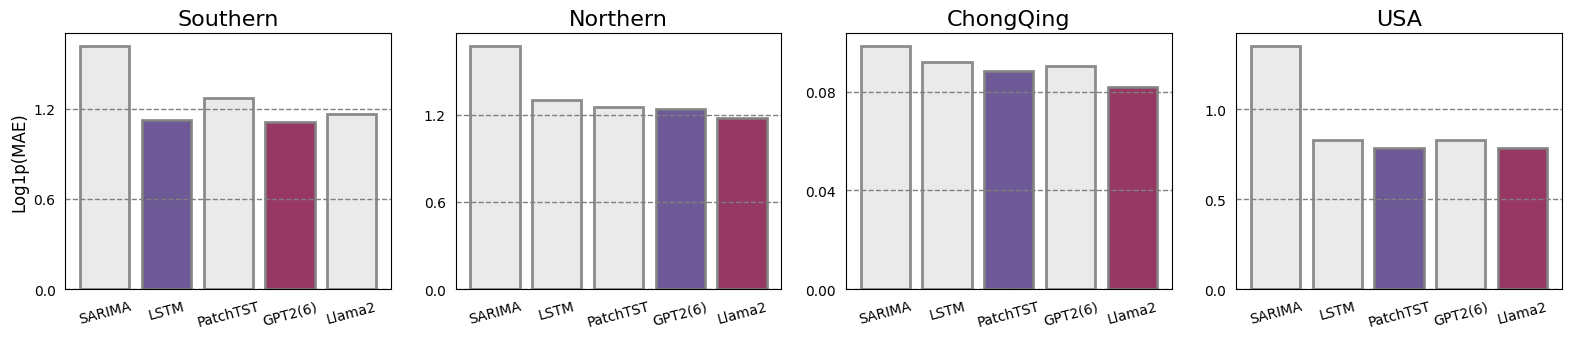

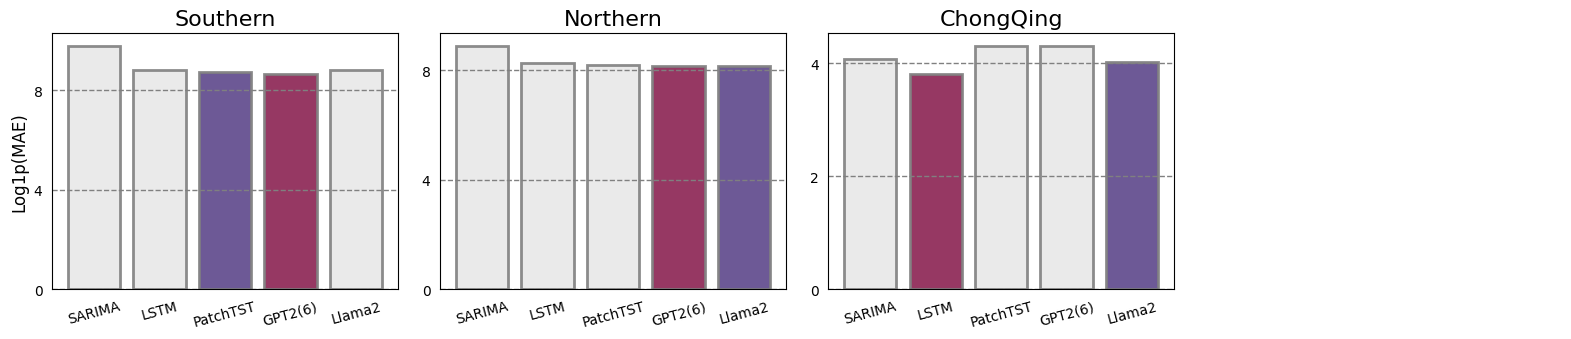

In [20]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from matplotlib.ticker import MaxNLocator

matplotlib.rcParams['font.size'] = 16  # 设置全局字体大小

# 数据集名称
dataset_names = ['Southern', 'Northern', 'ChongQing', 'USA', 'Southern', 'Northern', 'ChongQing']

if metric.values.max() > 10:
    metric_scaled = np.log1p(metric)
    MAE = f'Log1p({name})'
else:
    metric_scaled = metric
    MAE = name

fig1, axes1 = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))  # 1行4列

for i, ax in enumerate(axes1):  # 仅使用前4个位置
    mae_row_scaled = metric_scaled.iloc[i].values

    title = f"{dataset_names[i]}"

    max_idx = mae_row_scaled.argmax()
    min_idx = mae_row_scaled.argmin()
    second_max_idx = (mae_row_scaled.argsort())[-2]
    second_min_idx = (mae_row_scaled.argsort())[1]

    # 颜色列表，最小的柱子为酒红色，第二小的为紫色，其他为浅灰色
    # colors = ['#8B2252' if idx == max_idx else '#5D478B' if idx == second_max_idx else '#E8E8E8'
    #           for idx in range(len(mae_row_scaled))]
    colors = ['#8B2252' if idx == min_idx else '#5D478B' if idx == second_min_idx else '#E8E8E8'
              for idx in range(len(mae_row_scaled))]
    
    # 绘制柱状图，设置透明度
    ax.bar(metric.columns, mae_row_scaled, color=colors, alpha=0.9, edgecolor='grey', linewidth=2)

    # 设置标题、x轴和y轴标签
    ax.set_title(title, fontsize=16)  # 为每个子图设置标题
    
    # 仅在第一个子图设置y轴标签
    if i == 0:
        ax.set_ylabel(MAE, fontsize=12)  # y 轴名称设置为 MAE
    
    ax.grid(False)  # 禁用网格线

    ax.set_ylim(bottom=0)
    ax.yaxis.set_major_locator(MaxNLocator(nbins=3))  # 设置 y 轴的最大刻度数量
    
    # 设置x轴的位置并设置标签
    ax.set_xticks(range(len(metric.columns)))  # 设置x轴标签的位置
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
    ax.set_xticklabels(metric.columns, rotation=15, ha='center', fontsize=10)  # 设置x轴标签并旋转
    ax.tick_params(axis='y', which='both', left=False, right=False, labelsize=10)  # 隐藏y轴刻度线

    ax.grid(True, linestyle='--', color='grey', axis='y', which='both', linewidth=1)

# fig1.text(1.04, 0.14, 'Positive Rate', va='bottom', ha='center', rotation=0, fontsize=16, fontweight='bold')
fig1.tight_layout(rect=[0, 0.03, 1, 0.95]) 

# 显示第一张图
plt.show()

# 创建第二张图：1 行 3 列的子图
fig2, axes2 = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))  # 1行3列

# 绘制后三个数据集的 mae（第二张图）
for i, ax in enumerate(axes2):  # 仅使用前3个位置
    if i < 3:
        mae_row_scaled = metric_scaled.iloc[i + 4].values

        title = f"{dataset_names[i + 4]}"

        max_idx = mae_row_scaled.argmax()
        second_max_idx = (mae_row_scaled.argsort())[-2]
        min_idx = mae_row_scaled.argmin()
        second_min_idx = (mae_row_scaled.argsort())[1]

        # 颜色列表，最小的柱子为酒红色，第二小的为紫色，其他为浅灰色
        # colors = ['#8B2252' if idx == max_idx else '#5D478B' if idx == second_max_idx else '#E8E8E8'
        #           for idx in range(len(mae_row_scaled))]
        colors = ['#8B2252' if idx == min_idx else '#5D478B' if idx == second_min_idx else '#E8E8E8'
                for idx in range(len(mae_row_scaled))]

        # 绘制柱状图，设置透明度
        ax.bar(metric.columns, mae_row_scaled, color=colors, alpha=0.9, edgecolor='grey', linewidth=2)
        
        # 设置标题、x轴和y轴标签
        ax.set_title(title, fontsize=16)  # 为每个子图设置标题
        
        # 仅在第一个子图设置y轴标签
        if i == 0:
            ax.set_ylabel(MAE, fontsize=12)  # y 轴名称设置为 MAE
        
        ax.grid(False)  # 禁用网格线

        # 设置 y 轴从 0 开始
        ax.set_ylim(bottom=0)

        ax.yaxis.set_major_locator(MaxNLocator(nbins=3))

        # 设置x轴的位置并设置标签
        ax.set_xticks(range(len(metric.columns)))  # 设置x轴标签的位置
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
        ax.set_xticklabels(metric.columns, rotation=15, ha='center', fontsize=10)  # 设置x轴标签并旋转
        ax.tick_params(axis='y', which='both', left=False, right=False, labelsize=10)  # 隐藏y轴刻度线

        ax.grid(True, linestyle='--', color='grey', axis='y', which='both', linewidth=1)

axes2[-1].axis('off')
fig2.tight_layout(rect=[0, 0.03, 1, 0.95])

# 显示第二张图
plt.show()

# 在绘制完图像之后保存
fig1.savefig(f'/data_disk/lichx/NeurIPS2023-One-Fits-All/Long-term_Forecasting/Output/11_13_png/{name}1_5models.pdf', dpi=300, bbox_inches='tight')
fig2.savefig(f'/data_disk/lichx/NeurIPS2023-One-Fits-All/Long-term_Forecasting/Output/11_13_png/{name}2_5models.pdf', dpi=300, bbox_inches='tight')


In [8]:
df = pd.DataFrame(data_cn)
print(df)
df = df[df['Best1'] != 0]
df

      Model  Best1  Best2  Best3  Best4  Best5
0    SARIMA      2      2      2      2      1
1      LSTM      2      0      0      0      1
2  PatchTST      0      0      1      0      1
3   GPT2(6)      2      2      0      3      0
4      GPT4      0      0      0      1      1
5    Llama2      0      2      3      0      2
6    Llama3      0      0      0      0      0


,Model,Best1,Best2,Best3,Best4,Best5
0,SARIMA,2,2,2,2,1
1,LSTM,2,0,0,0,1
3,GPT2(6),2,2,0,3,0


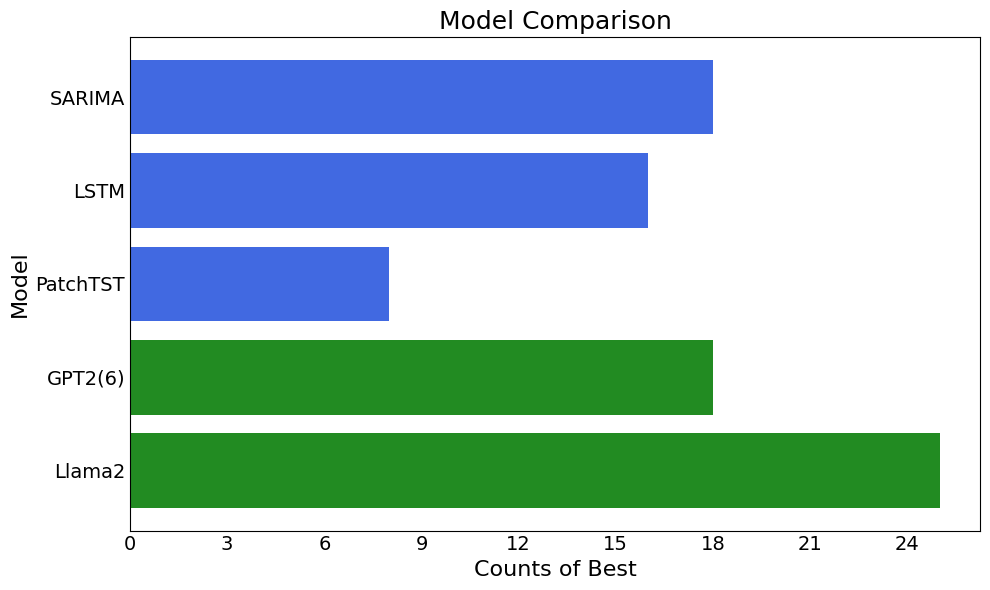

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import Patch

# 模型数据
# data_all = {
#     "Model": [
#         "SARIMA", "LSTM", "PatchTST", "GPT2(6)", "GPT2",
#         "GPT4", "Llama2", "Llama3"
#     ],
#     "Sum": [17, 16, 7, 16, 2, 3, 21, 2]
# }

data_all = {
    "Model": [
        "SARIMA", "LSTM", "PatchTST", "GPT2(6)", "Llama2"
    ],
    "Best": [17, 5, 2, 9, 9],
    "Sum": [18, 16, 8, 18, 25]
}

df = pd.DataFrame(data_all)
df = df.iloc[::-1]

fig, ax = plt.subplots(figsize=(10, 6))

color1 = 'forestgreen'
color2 = 'royalblue'
colors = [color1 if i < 2 else color2 for i in range(len(df))]

# bars = ax.barh(df["Model"], df["Best"], color=colors, alpha=1)
bars = ax.barh(df["Model"], df["Sum"], color=colors, alpha=1)

ax.set_xlabel("Counts of Best", fontsize=16)
ax.set_ylabel("Model", fontsize=16)
ax.set_title("Model Comparison", fontsize=18)

ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

ax.tick_params(axis='x', which='both', labelsize=14, length=0)
ax.tick_params(axis='y', which='both', labelsize=14, length=0)
ax.grid(False)

legend_elements = [
    Patch(facecolor=color2, edgecolor='black', label='Classical Models'),
    Patch(facecolor=color1, edgecolor='black', label='Large Language Models')
]
# ax.legend(handles=legend_elements, loc='lower right', fontsize=14, bbox_to_anchor=(1, 0.025))

plt.tight_layout()

plt.savefig(f'/data_disk/lichx/NeurIPS2023-One-Fits-All/Long-term_Forecasting/Output/11_13_png/Counts_of_all.pdf', dpi=300, bbox_inches='tight')

# 显示图表
plt.show()
plt.close()

In [21]:
print(df)
columns = df.columns[1:]
for i, column in enumerate(columns):

        # 剔除为0的模型
        data_filtered = df[df[column] > 0]
        print(data_filtered)


      Model  Southern  Northern  USA  ILI of Southern  ILI of Northern
6    Llama3         0         0    0                0                0
5    Llama2         0         2    3                0                2
4      GPT4         0         0    0                1                1
3   GPT2(6)         2         2    0                3                0
2  PatchTST         0         0    1                0                1
1      LSTM         2         0    0                0                1
0    SARIMA         2         2    2                2                1
     Model  Southern  Northern  USA  ILI of Southern  ILI of Northern
3  GPT2(6)         2         2    0                3                0
1     LSTM         2         0    0                0                1
0   SARIMA         2         2    2                2                1
     Model  Southern  Northern  USA  ILI of Southern  ILI of Northern
5   Llama2         0         2    3                0                2
3  GPT2(6)  

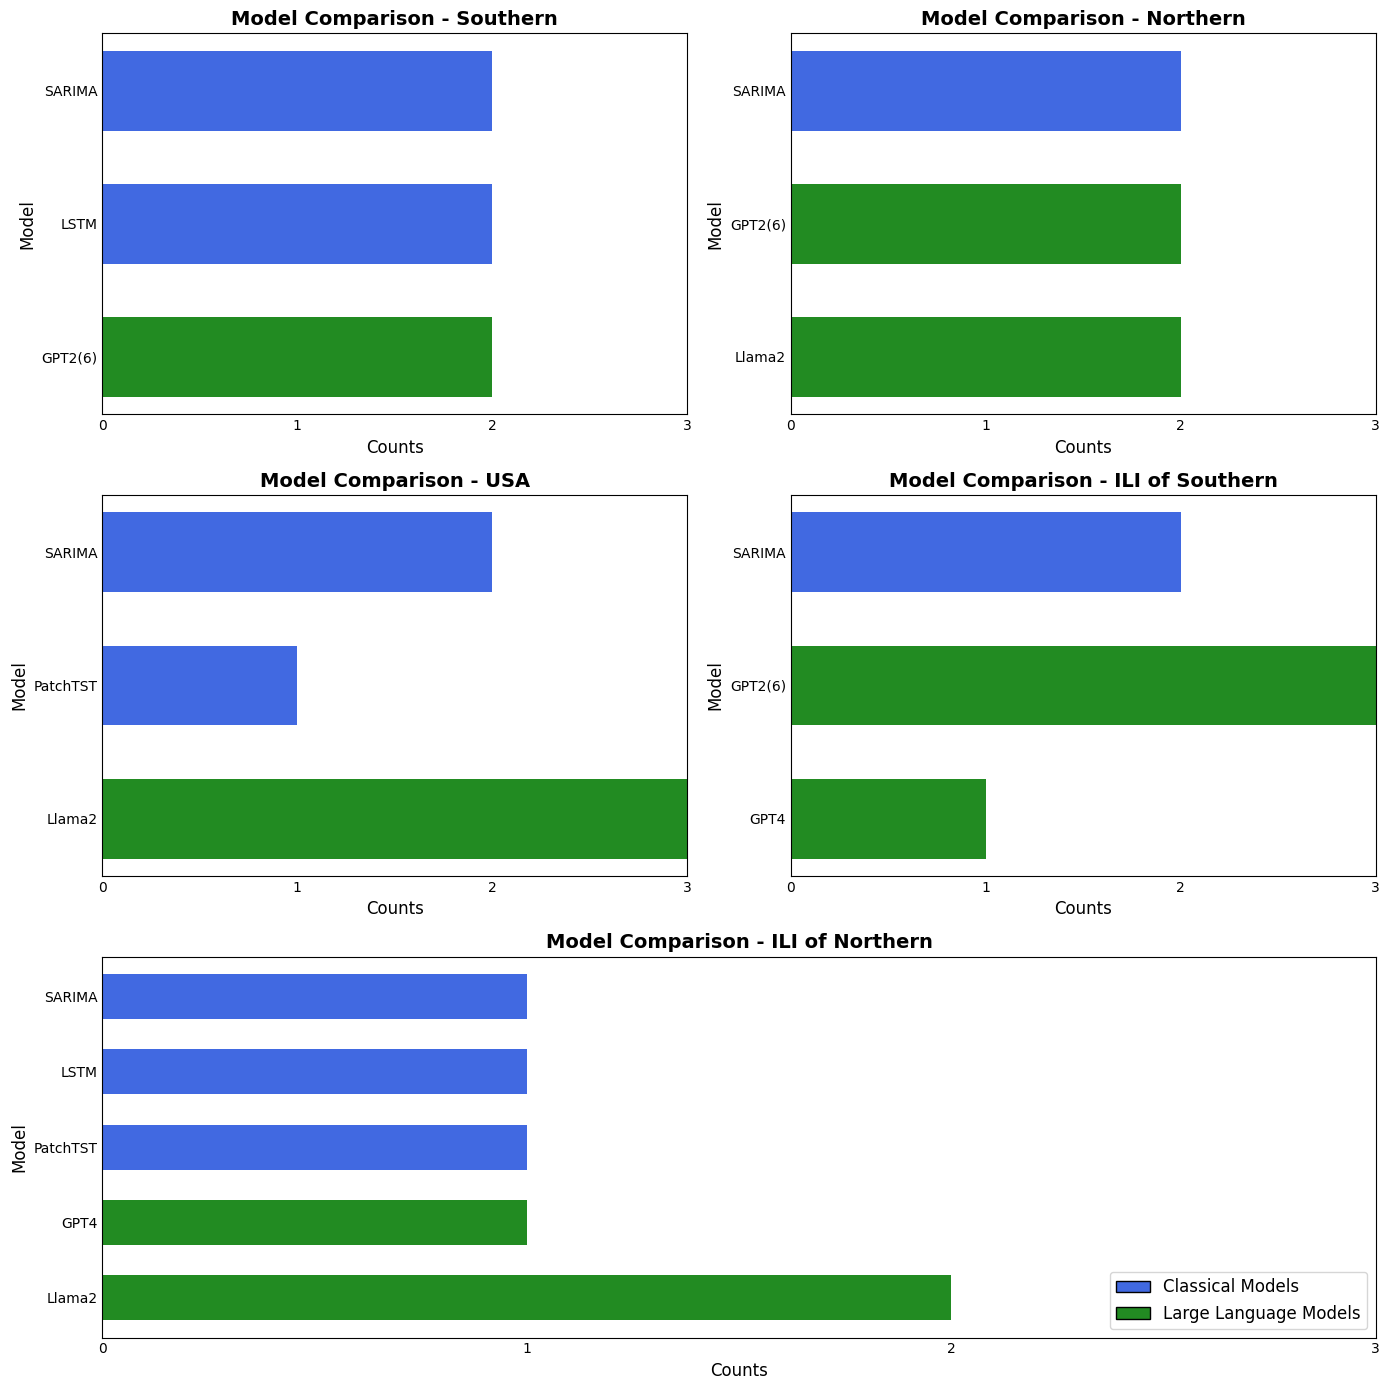

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# 数据
data_cn = {
    "Model": [
        "SARIMA", "LSTM", "PatchTST", "GPT2(6)",
        "GPT4", "Llama2", "Llama3"
    ],
    "Southern": [2, 2, 0, 2, 0, 0, 0],
    "Northern": [2, 0, 0, 2, 0, 2, 0],
    "USA": [2, 0, 1, 0, 0, 3, 0],
    "ILI of Southern": [2, 0, 0, 3, 1, 0, 0],
    "ILI of Northern": [1, 1, 1, 0, 1, 2, 0]
}

# 转换为 DataFrame
df = pd.DataFrame(data_cn)

# 反转行顺序
df = df.iloc[::-1]

# 绘图函数
# 将图表放入3行2列的画布中
# 修改第五张图占据第三行全部
def plot_multiple_charts_full_width_fifth(data):
    fig, axes = plt.subplots(3, 2, figsize=(14, 14))
    fig.subplots_adjust(hspace=0.4, wspace=0.3)  # 调整子图之间的间距

    columns = data.columns[1:]  # 数据集列名
    color1 = 'forestgreen'
    color2 = 'royalblue'
    legend_elements = [
        Patch(facecolor=color2, edgecolor='black', label='Classical Models'),
        Patch(facecolor=color1, edgecolor='black', label='Large Language Models')
    ]

    for i, column in enumerate(columns):
        if i < 4:
            row, col = divmod(i, 2)  # 前四张图计算子图的行列索引
            ax = axes[row, col]
        else:
            # 第五张图占据第三行两列
            ax = fig.add_subplot(3, 1, 3)  # 合并第三行两列为一个完整子图
            axes[2, 0].axis('off')  # 隐藏原有子图
            axes[2, 1].axis('off')

        # 剔除为0的模型
        data_filtered = data[data[column] > 0]
        colors = [color1 if "GPT" in model or "Llama" in model else color2 for model in data_filtered["Model"]]

        # 绘制条形图
        ax.barh(data_filtered["Model"], data_filtered[column], color=colors, alpha=1, height=0.6)
        ax.set_xlim(0, 3)  # 设置x轴范围
        
        # 设置标题和标签
        ax.set_title(f"Model Comparison - {column}", fontsize=14, fontweight="bold")
        ax.set_xlabel("Counts", fontsize=12)
        ax.set_ylabel("Model", fontsize=12)
        
        # 调整坐标和网格
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
        ax.tick_params(axis='x', which='both', length=0)
        ax.tick_params(axis='y', which='both', length=0)
        ax.grid(False)

        if i == 4:  # 第五张图添加图例
            ax.legend(handles=legend_elements, loc='lower right', fontsize=12)

    # 显示所有图
    plt.tight_layout()
    plt.show()

# 绘制合并的子图
plot_multiple_charts_full_width_fifth(df)




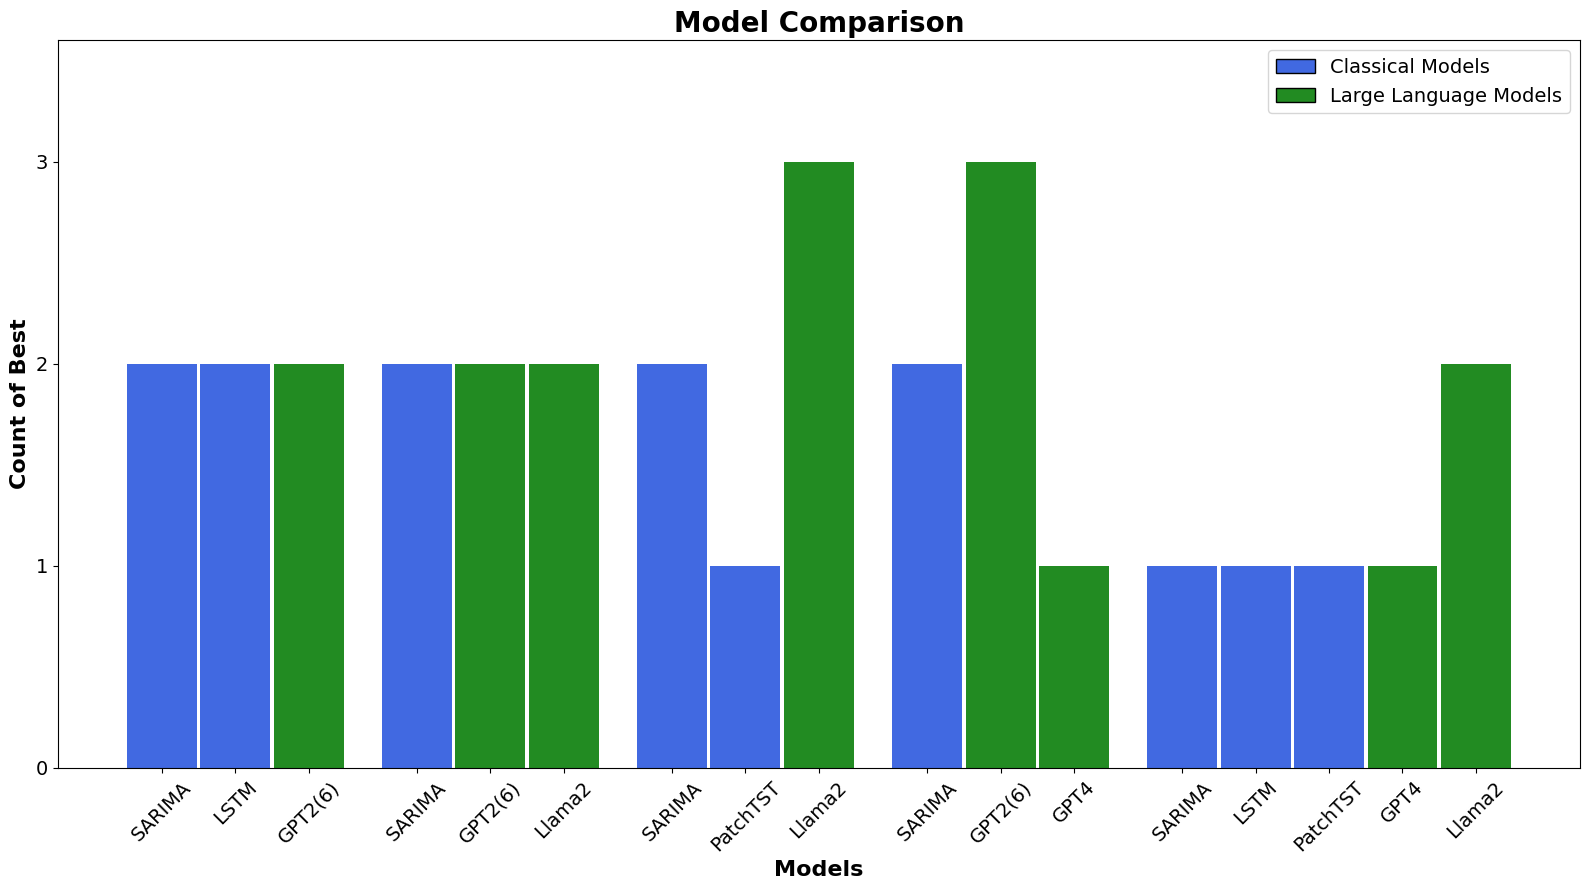

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# 数据
data_cn = {
    "Model": [
        "SARIMA", "LSTM", "PatchTST", "GPT2(6)",
        "GPT4", "Llama2", "Llama3"
    ],
    "Southern": [2, 2, 0, 2, 0, 0, 0],
    "Northern": [2, 0, 0, 2, 0, 2, 0],
    "USA": [2, 0, 1, 0, 0, 3, 0],
    "ILI of Southern": [2, 0, 0, 3, 1, 0, 0],
    "ILI of Northern": [1, 1, 1, 0, 1, 2, 0]
}

# 转换为 DataFrame
df = pd.DataFrame(data_cn)

# 修改为去掉网格，并在y轴仅保留模型名称
# 修改代码以确保同一数据集内的模型柱子之间有间隔
def plot_filtered_grouped_bar_with_spacing(data, title):
    fig, ax = plt.subplots(figsize=(16, 9))
    
    # 数据集列名和模型
    columns = data.columns[1:]
    bar_width = 0.1  # 每个柱子的宽度
    dataset_gap = 0.05  # 数据集间的间隔
    model_gap = 0.005  # 模型柱子之间的间隔

    x_positions = []
    flat_x_labels = []
    all_heights = []
    dataset_positions = []

    # 设置颜色
    color1 = 'forestgreen'
    color2 = 'royalblue'

    # 计算柱子的位置并绘制图表
    for i, column in enumerate(columns):
        # 筛选当前数据集中大于0的模型
        data_filtered = data[data[column] > 0]
        num_models = len(data_filtered)

        # 计算x位置，增加模型间的间隔
        start_pos = i * (3 * (bar_width + model_gap) + dataset_gap)
        positions = [start_pos + j * (bar_width + model_gap) for j in range(num_models)]
        x_positions.extend(positions)

        flat_x_labels.extend([f"{model}" for model in data_filtered["Model"]])
        all_heights.extend(data_filtered[column])

        colors = [
            color1 if "GPT" in model or "Llama" in model else color2 
            for model in data_filtered["Model"]
        ]
        ax.bar(positions, data_filtered[column], width=bar_width, color=colors, alpha=1)
        
    # 设置x轴刻度和标签
    ax.set_xticks(x_positions)
    ax.set_xticklabels(flat_x_labels, fontsize=14, rotation=45, ha='center')

    # 设置标题和标签
    ax.set_title(title, fontsize=20, fontweight="bold")
    ax.set_xlabel("Models", fontsize=16, fontweight="bold")
    ax.set_ylabel("Count of Best", fontsize=16, fontweight="bold")
    
    # 添加图例
    legend_elements = [
        Patch(facecolor=color2, edgecolor='black', label='Classical Models'),
        Patch(facecolor=color1, edgecolor='black', label='Large Language Models')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=14)
    
    # 动态调整y轴范围
    max_value = max(all_heights) if all_heights else 0
    ax.set_ylim(0, max_value * 1.2)
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    ax.tick_params(axis='y', labelsize=14)
    ax.grid(False)

    plt.tight_layout()
    plt.savefig(f'/data_disk/lichx/NeurIPS2023-One-Fits-All/Long-term_Forecasting/Output/11_13_png/Counts_of_CN.pdf', dpi=300, bbox_inches='tight')
    plt.show()

# 绘制增加模型柱子间隔的柱状图
plot_filtered_grouped_bar_with_spacing(df, "Model Comparison")



# 11/29

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FuncFormatter

In [27]:
# 自定义的格式化函数
def custom_formatter(x, pos):
    if x < 10:
        return f"{x:.2f}"  # 小于10保留两位小数
    elif x < 100:
        return f"{x:.1f}"  # 10到100之间保留一位小数
    else:
        return f"{int(x)}"  # 大于等于100保留整数

In [32]:
# data = pd.read_excel("/data_disk/lichx/NeurIPS2023-One-Fits-All/Long-term_Forecasting/Output/summary_llama_layer_values.xlsx", sheet_name=1)
data = pd.read_excel("/data_disk/lichx/NeurIPS2023-One-Fits-All/Long-term_Forecasting/Output/summary_epochs_with_gpt2_layer_values.xlsx", sheet_name=1)

In [33]:
dt0 = data[data['if_inverse']==0]
dt1 = data[data['if_inverse']==1]
dt0.shape, dt1.shape

((12, 8), (12, 8))

In [34]:
dt = dt1.copy()
dt = dt.reset_index(drop=True)
dt.columns = ['gpt_layer', 'if_inverse', 'SpearmanR', 'PearsonR', 'MAE', 'MSE', 'MAPE', 'SMAPE']
dt.columns

Index(['gpt_layer', 'if_inverse', 'SpearmanR', 'PearsonR', 'MAE', 'MSE',
       'MAPE', 'SMAPE'],
      dtype='object')

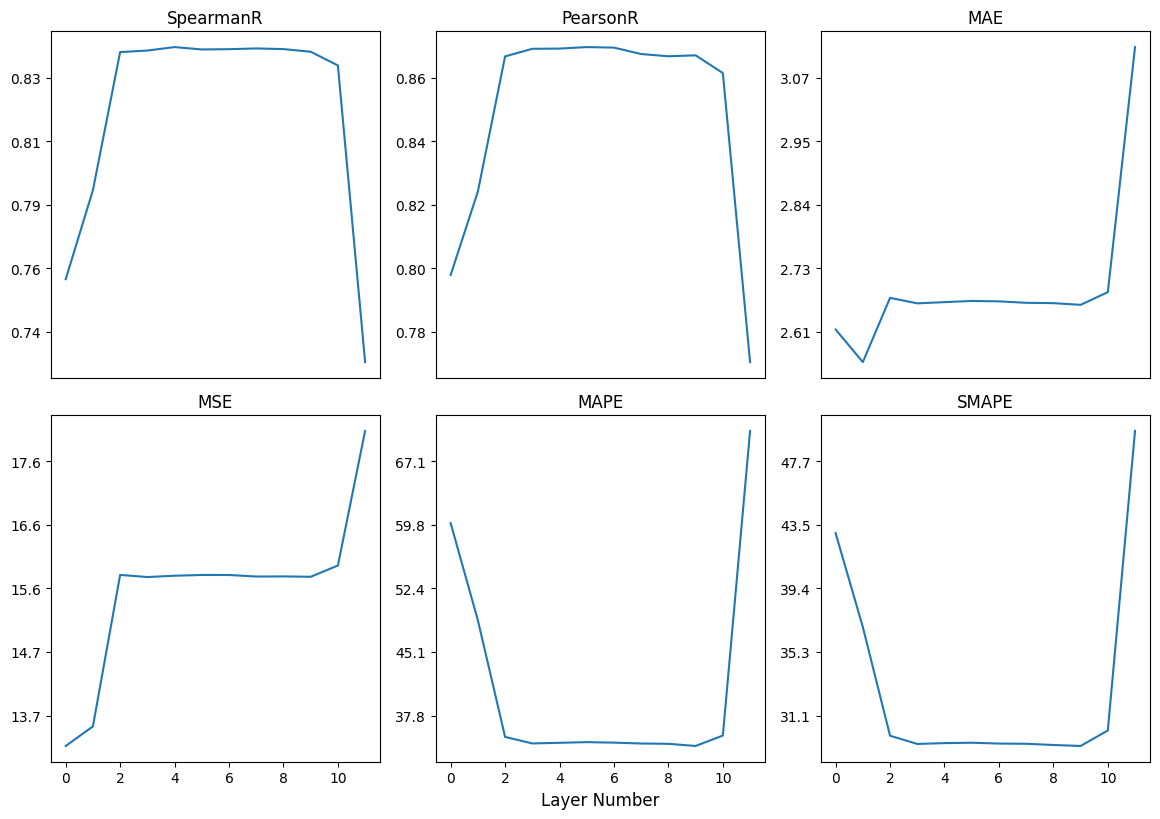

In [36]:
fig, axes = plt.subplots(2, 3, figsize=(11.7, 8.3))  # A4尺寸 (宽, 高)，单位是英寸
axes = axes.flatten()  # 展平数组以便于循环

for i in range(dt.shape[1] - 2):
    axes[i].plot(dt.iloc[:, i + 2])
    axes[i].set_title(f"{dt.columns[i + 2]}", fontsize=12)  # 设置标题字体大小
    axes[i].tick_params(axis='both', labelsize=10)  # 设置刻度字体大小

    # 获取当前y轴的最小和最大值
    y_min, y_max = axes[i].get_ylim()

    # 扩展y轴范围，避免最小值和最大值作为刻度
    y_range = y_max - y_min
    new_y_min = y_min - 0.05 * y_range  # 在下方扩展5%
    new_y_max = y_max + 0.05 * y_range  # 在上方扩展5%

    # 使用np.linspace生成均匀分布的刻度，避免包含y_min和y_max
    axes[i].set_yticks(np.linspace(new_y_min, new_y_max, 7)[1:-1])  # 取掉第一和最后一个刻度
    axes[i].yaxis.set_major_formatter(FuncFormatter(custom_formatter))
    
    # 去掉第一行子图的x轴标签和刻度
    if i < 3:
        axes[i].set_xticklabels([])  # 去掉x轴刻度标签
        axes[i].set_xticks([])       # 去掉x轴刻度

axes[4].set_xlabel("Layer Number", fontsize=12)  # 添加x轴标签

plt.tight_layout()  # 自动调整布局
plt.savefig("/data_disk/lichx/NeurIPS2023-One-Fits-All/Long-term_Forecasting/Output/11_13_png/metrics_with_different_gpt_layers.pdf", dpi=300, bbox_inches='tight')
plt.show()

# 12/2

In [72]:
## pred len

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator

In [2]:
data = pd.read_excel("/data_disk/lichx/NeurIPS2023-One-Fits-All/Long-term_Forecasting/Output/summary_pred_len.xlsx", sheet_name=1)

dt0 = data[data['if_inverse']==0].reset_index(drop=True)
dt1 = data[data['if_inverse']==1].reset_index(drop=True)
data.shape, dt0.shape, dt1.shape

((40, 9), (20, 9), (20, 9))

In [3]:
dt = dt1.copy()
dt = dt.fillna(0)

metrics = ['model', 'pred_len', 'if_inverse', 'SpearmanR', 'PearsonR', 'MAE', 'MSE', 'MAPE', 'SMAPE']
dt.columns = metrics
dt

,model,pred_len,if_inverse,SpearmanR,PearsonR,MAE,MSE,MAPE,SMAPE
0,Llama2,1,1,0.000000,0.000000,2.160800,9.796200,48.882367,41.063733
1,Llama2,4,1,0.595833,0.623067,2.341000,10.786367,56.406933,42.655300
2,Llama2,8,1,0.761300,0.771067,2.292867,10.701300,47.551267,37.008667
3,Llama2,13,1,0.816400,0.850700,2.230867,10.215333,43.450867,32.689033
4,SARIMA,1,1,0.000000,0.000000,0.213468,0.045569,11.383878,10.770810
5,SARIMA,4,1,-0.800000,-0.829668,1.774662,3.873708,78.914317,114.472564
6,SARIMA,8,1,0.595238,0.847809,6.736079,48.707112,256.177688,183.103265
7,SARIMA,13,1,0.901099,0.979280,4.338746,33.200655,64.627619,41.876583
8,LSTM,1,1,0.000000,0.000000,2.375833,11.918633,54.951567,39.418633
9,LSTM,4,1,0.608333,0.606984,2.693800,14.485233,64.219967,41.499600


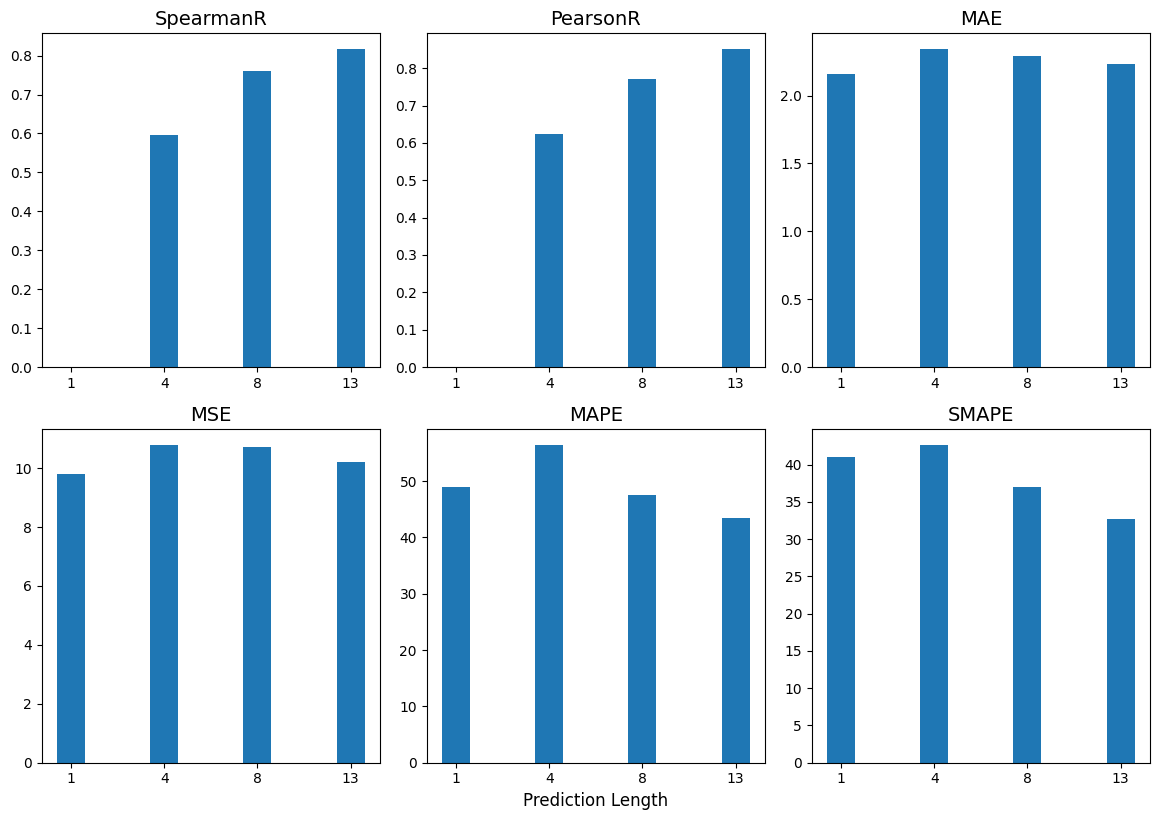

In [43]:
fig, axes = plt.subplots(2, 3, figsize=(11.7, 8.3))  # A4纸尺寸（以英寸为单位）
axes = axes.flatten()
# 每个指标在 DataFrame 中的列索引
metric_columns = ['SpearmanR', 'PearsonR', 'MAE', 'MSE', 'MAPE', 'SMAPE']

# 获取所有 pred_len 的唯一值
all_pred_len = np.sort(dt['pred_len'].unique())

# 遍历每个指标并绘制柱状图
for i, ax in enumerate(axes):
    metric = metric_columns[i]
    
    # 获取该指标的数据，并去除缺失值
    data_to_plot = dt[['pred_len', metric]].dropna()
    
    # 创建 x 轴位置
    x = np.array([np.where(all_pred_len == val)[0][0] for val in data_to_plot['pred_len']])  # 将 pred_len 映射到统一的 x 轴位置
    xticks = all_pred_len  # 设置统一的 x 轴刻度

    bar_width = 0.3
    ax.bar(x, data_to_plot[metric], width=bar_width, label=metric)

    # 设置标题和标签，并调整字体大小
    ax.set_title(f'{metric}', fontsize=14)
    ax.set_ylabel(metric, fontsize=12)

    # 设置 x 轴刻度：保持一致的 x 轴刻度
    ax.set_xticks(np.arange(len(all_pred_len)))  # 设置统一的 x 轴刻度位置
    ax.set_xticklabels(all_pred_len, fontsize=10)  # 设置统一的 x 轴刻度标签

    # 第一行的子图：去掉 x 轴标签，相关系数子图的 pred_len=1 留空
    if i < 3:
        ax.set_xlabel('')  # 不显示 x 轴标签
    
    ax.set_ylabel('')

axes[4].set_xlabel("Prediction Length", fontsize=12)  # 添加x轴标签

# 调整子图之间的间距，防止标签重叠
plt.tight_layout()

# 保存图像到指定路径
plt.savefig("/data_disk/lichx/NeurIPS2023-One-Fits-All/Long-term_Forecasting/Output/11_13_png/metrics_with_different_pred_len.pdf", dpi=300, bbox_inches='tight')

# 显示图表
plt.show()
plt.close()

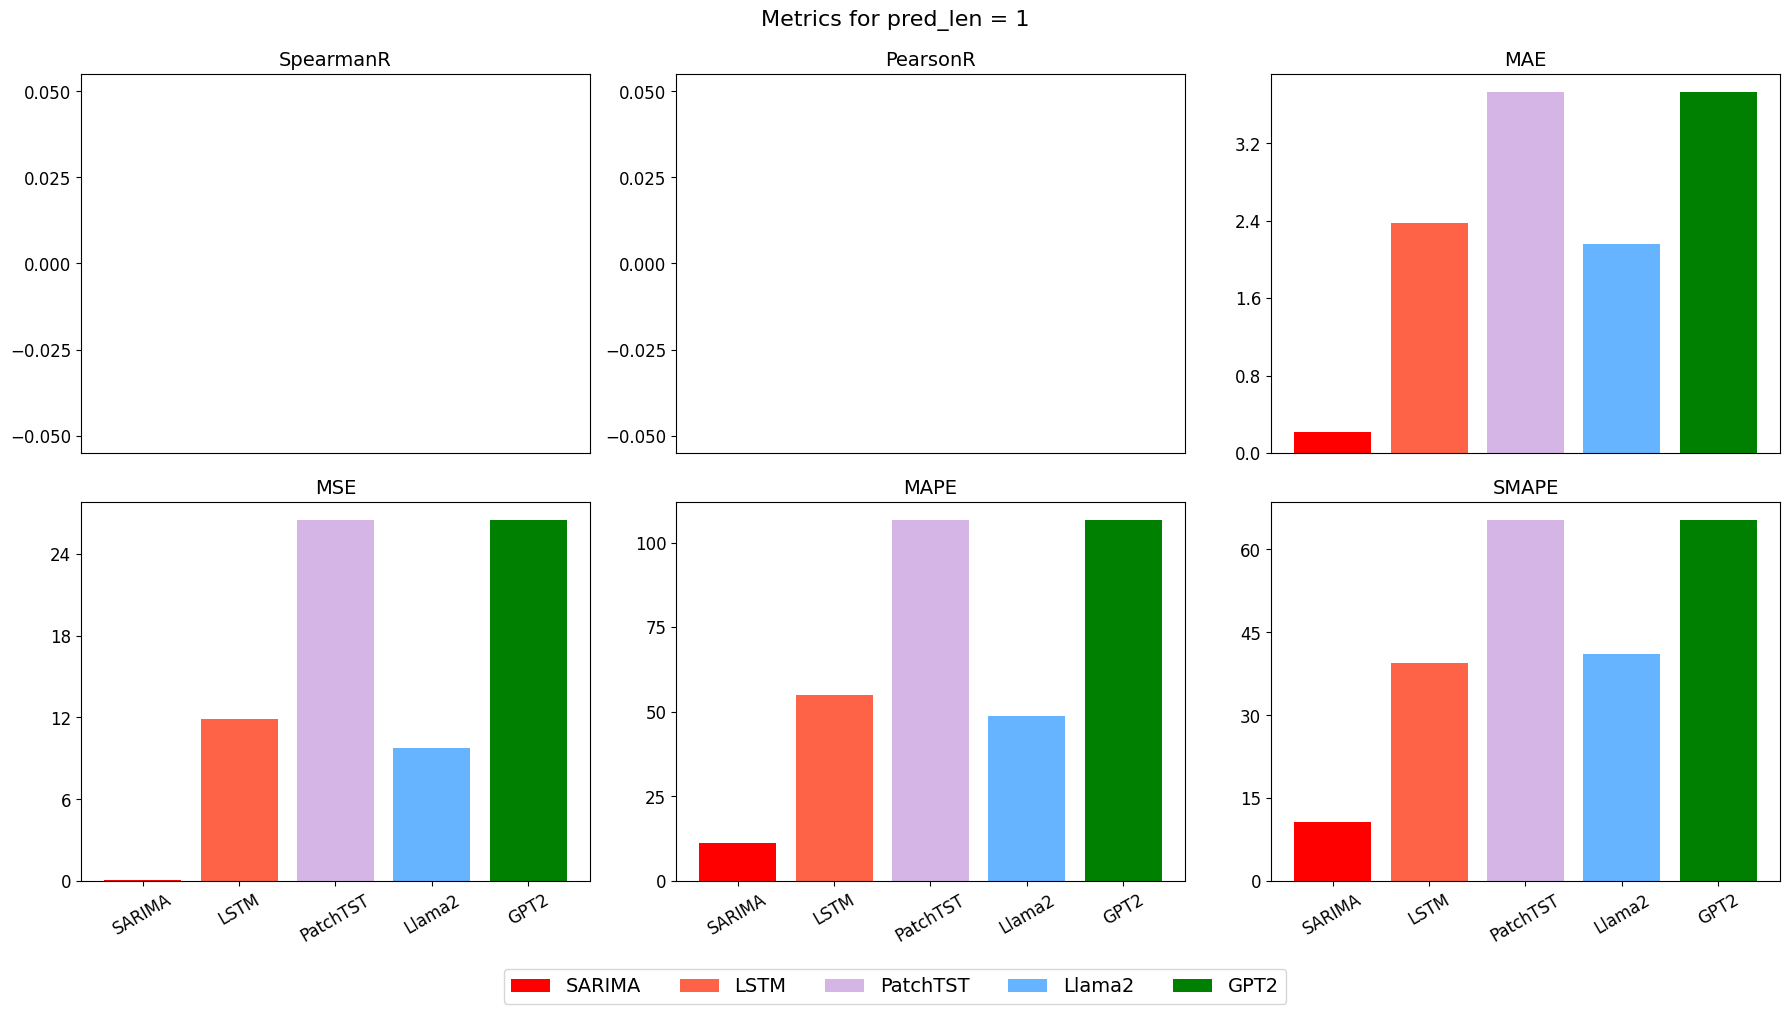

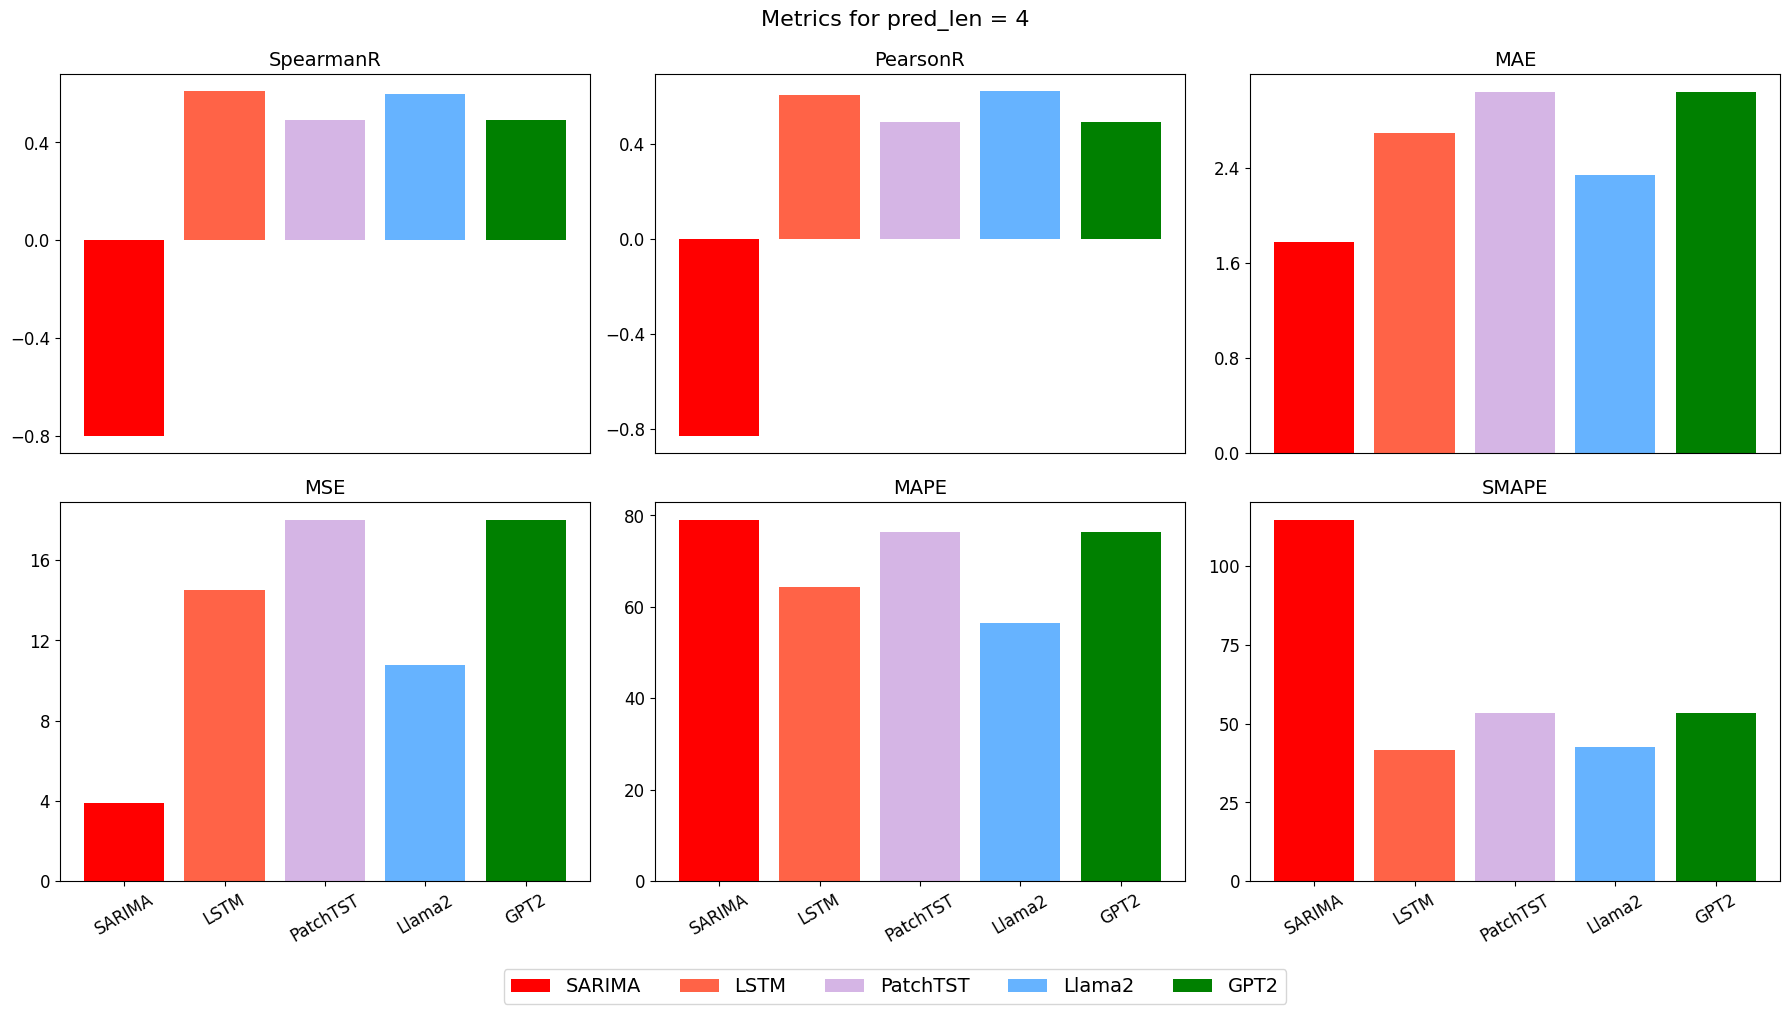

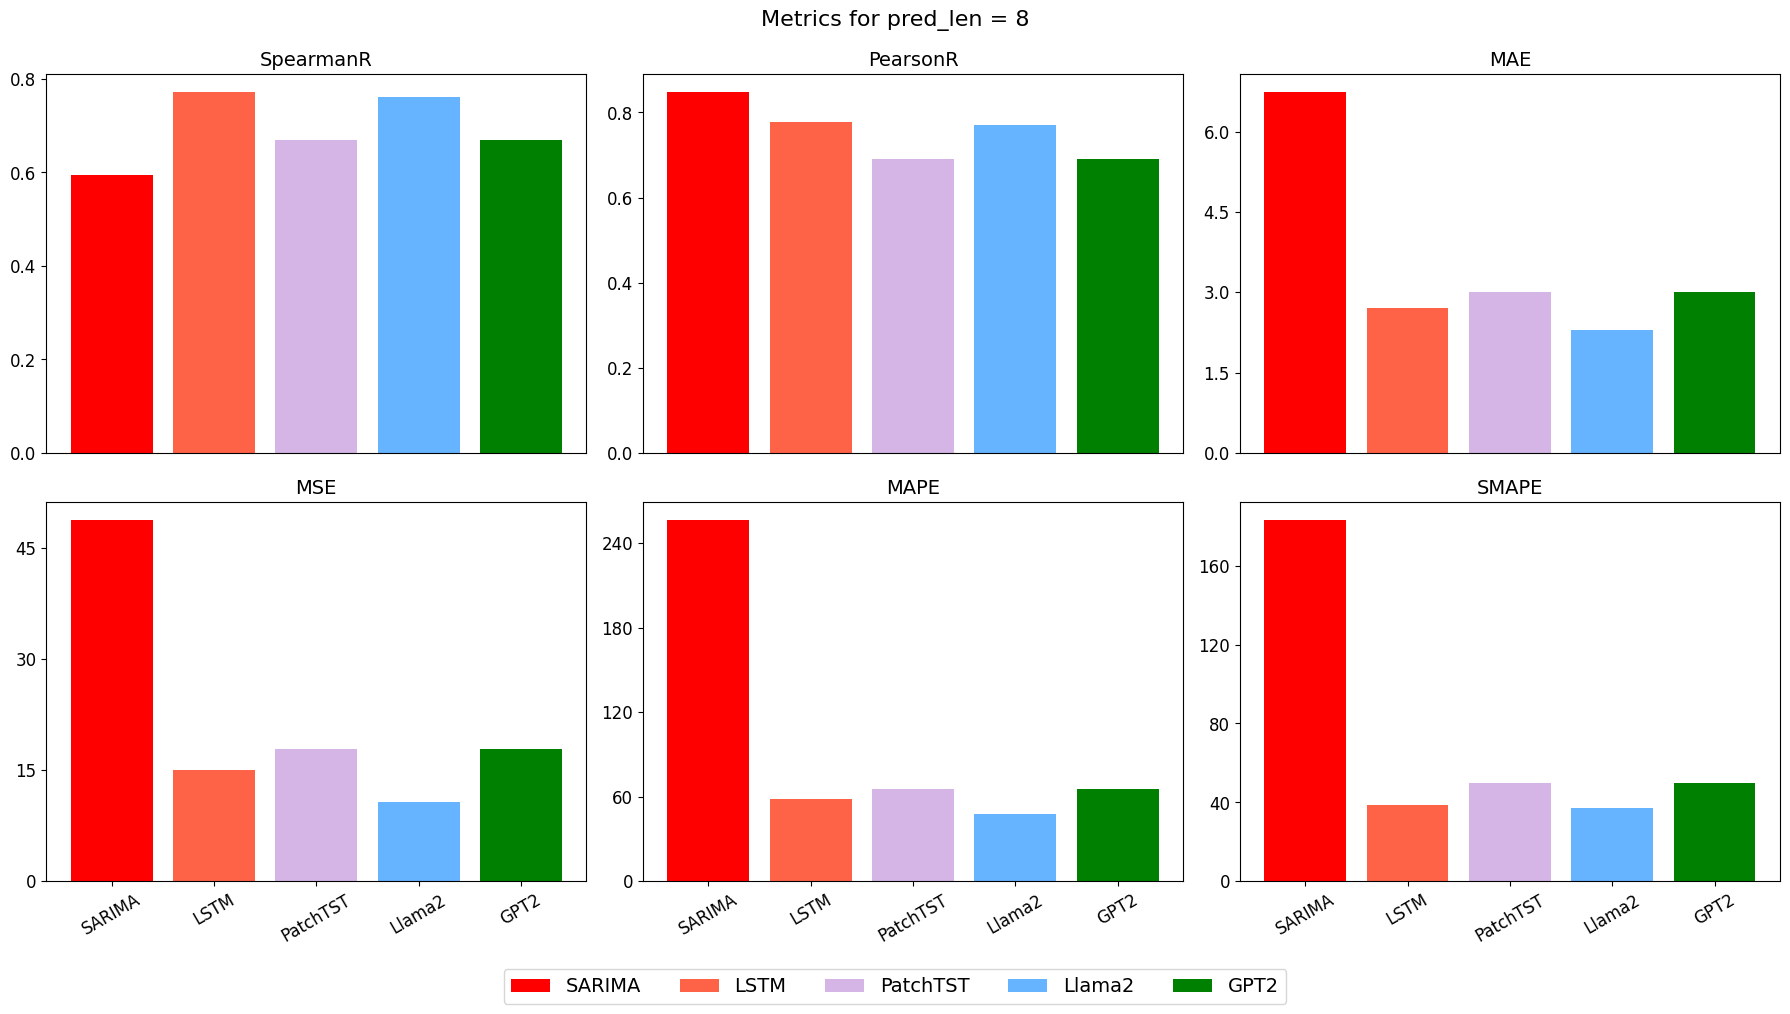

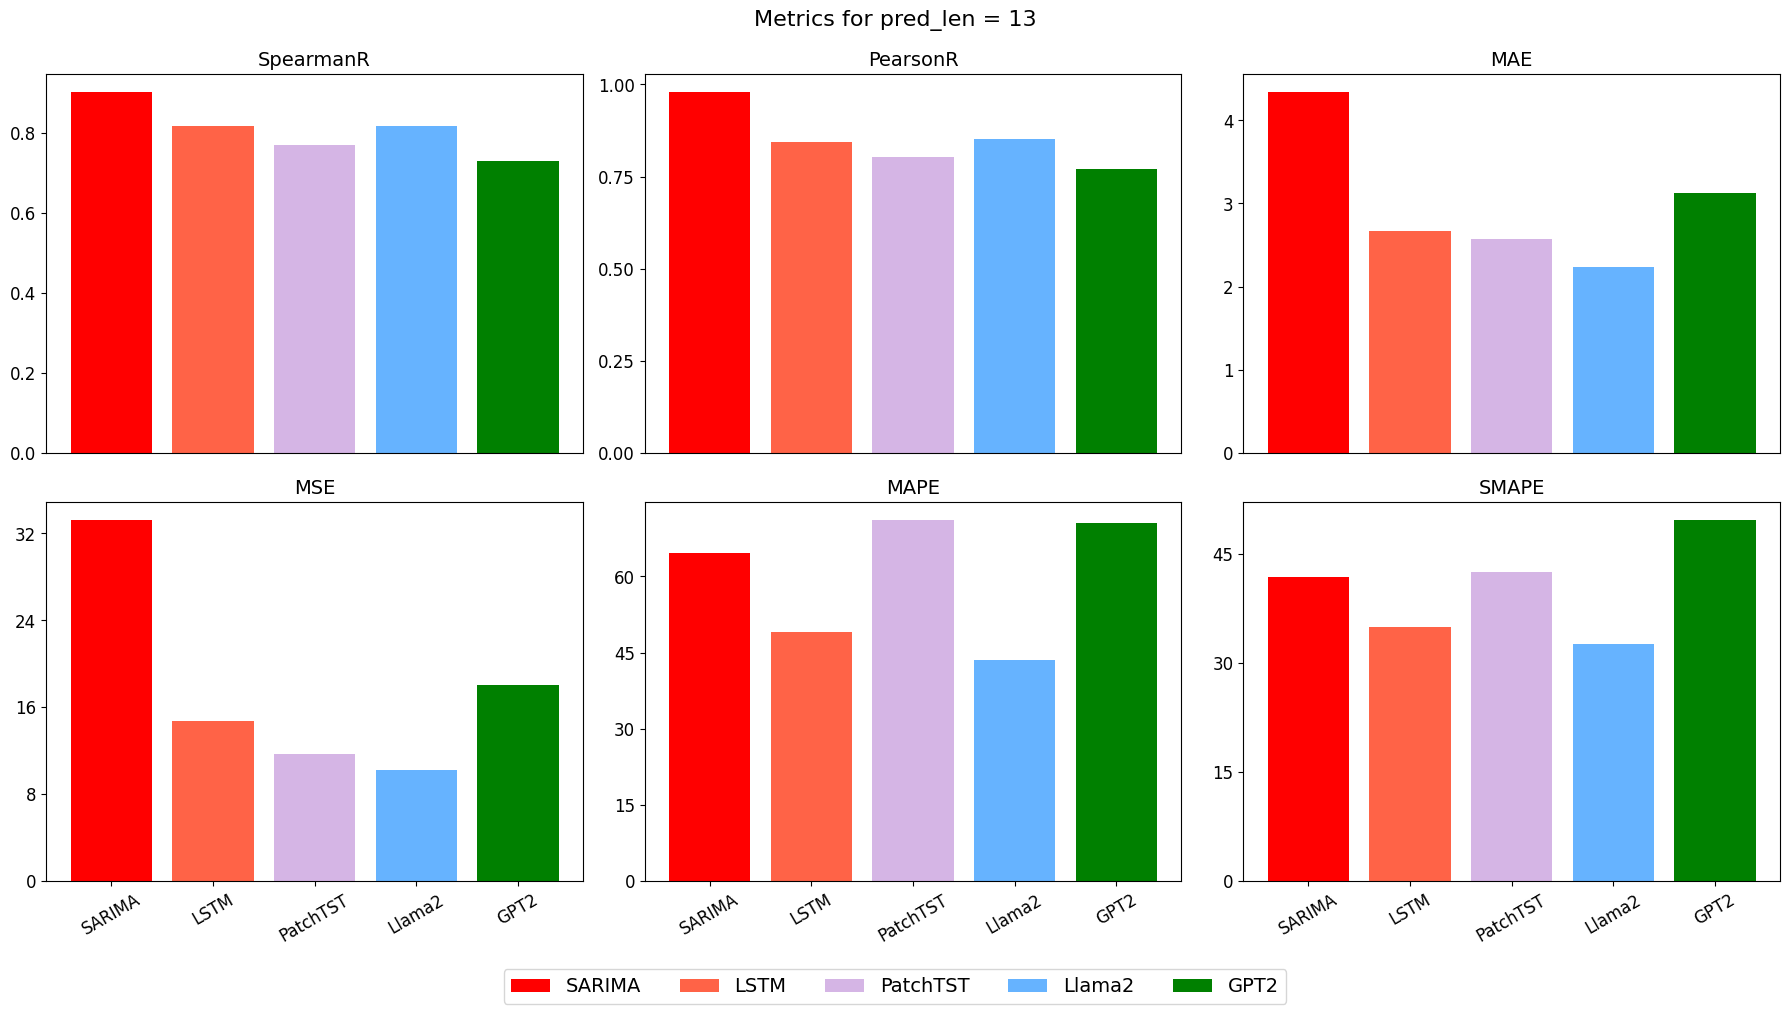

In [44]:
df = pd.DataFrame(dt)

# 获取唯一的预测长度
pred_lens = df["pred_len"].unique()

# 指标列表
metrics = ["SpearmanR", "PearsonR", "MAE", "MSE", "MAPE", "SMAPE"]

# 逐个预测长度绘制图表
# 用户指定的颜色
model_colors = {
    "Llama2": "#66b3ff",
    "GPT2": "green",
    "SARIMA": "red",
    "LSTM": "#ff6347",
    "PatchTST": "#d5b5e5"
}
model_order = ["SARIMA", "LSTM", "PatchTST", "Llama2", "GPT2"]
unique_models = df["model"].unique()

# 字体大小设置
font_size_title = 16
font_size_axis = 12
font_size_legend = 14

# 逐个预测长度绘制图表，使用用户指定的颜色
for pred_len in pred_lens:
    # 筛选当前预测长度的数据
    subset = df[df["pred_len"] == pred_len]
    
    # 创建图形
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'Metrics for pred_len = {pred_len}', fontsize=font_size_title, y=0.95)
    
    # 保存绘制的条形图对象，用于生成综合图例
    bars = []
    labels = []
    
    # 绘制每个指标
    for i, (ax, metric) in enumerate(zip(axes.flatten(), metrics)):
        for j, model in enumerate(model_order):
            color = model_colors.get(model, "gray")  # 默认为灰色，防止有模型不在字典里
            model_data = subset[subset["model"] == model]
            bar = ax.bar(j, model_data[metric].values[0], color=color)
            if metric == "SpearmanR":  # 只记录一次图例信息
                bars.append(bar[0])
                labels.append(model)
        
        ax.set_title(metric, fontsize=font_size_legend)
        
        # 第一行的三个子图去掉 x 轴刻度和标签
        if i < 3:
            ax.set_xticks([])
            ax.set_xticklabels([])
        else:
            ax.set_xticks(range(len(model_order)))
            ax.set_xticklabels(model_order, rotation=30, fontsize=font_size_axis)
        
        ax.tick_params(axis='both', which='major', labelsize=font_size_axis)
        
        # 限制y轴刻度个数为最大5个
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
    
    # 在图外部添加统一图例，放在图的下方
    fig.legend(bars, labels, loc='upper center', ncol=len(labels), bbox_to_anchor=(0.5, 0), fontsize=font_size_legend)
    
    # 调整布局并显示图表
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f"/data_disk/lichx/NeurIPS2023-One-Fits-All/Long-term_Forecasting/Output/12_6_png/pred_len_{pred_len}.pdf", format="pdf", bbox_inches='tight')
    plt.show()



In [4]:
model_colors = {
    "Llama2": "#abd9e9",
    "GPT2(6)": "#a6d96a",
    "SARIMA": "#d7191c",
    "LSTM": "#7b3294",
    "PatchTST": "#fdae61"
}

model_order = ["Llama2", "GPT2(6)", "SARIMA", "LSTM", "PatchTST"]
metrics_visual = ["SpearmanR", "PearsonR", "MAE", "MSE", "MAPE", "SMAPE"]

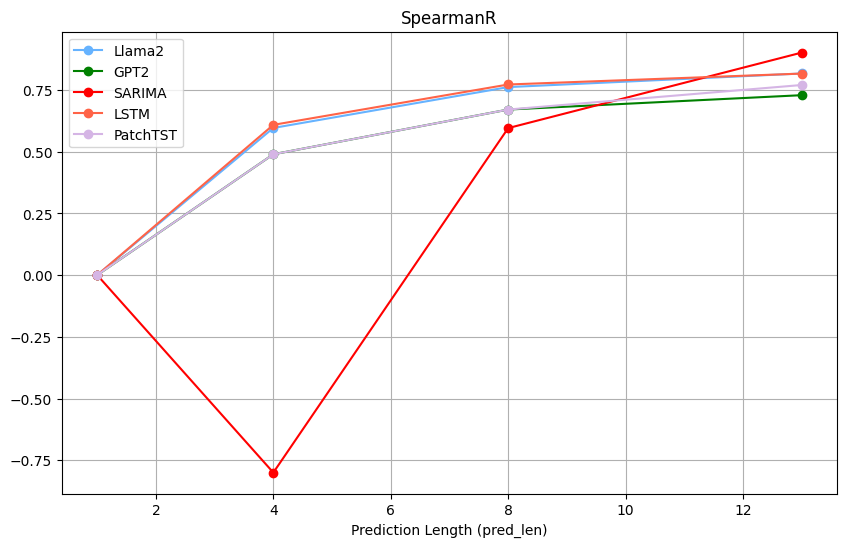

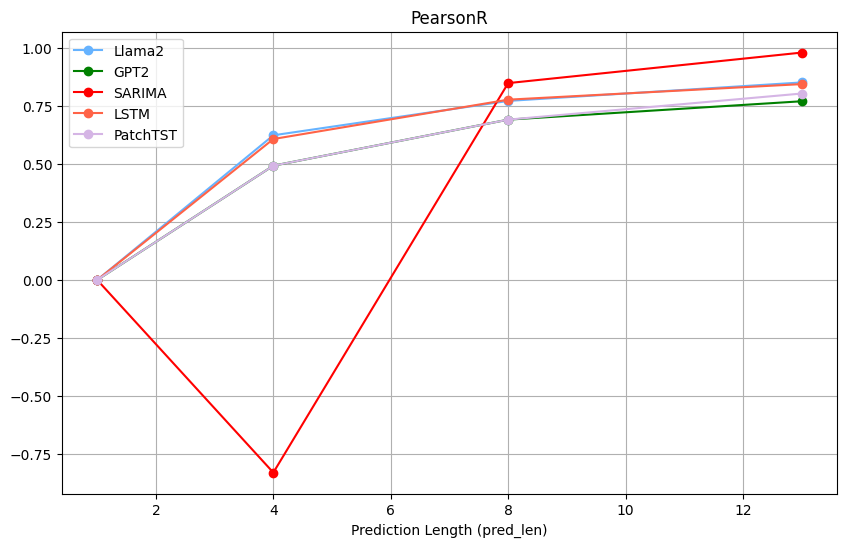

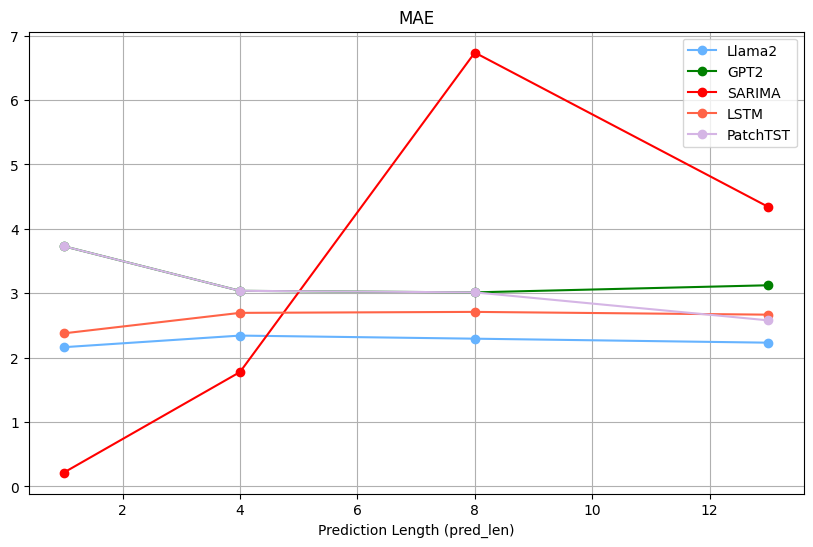

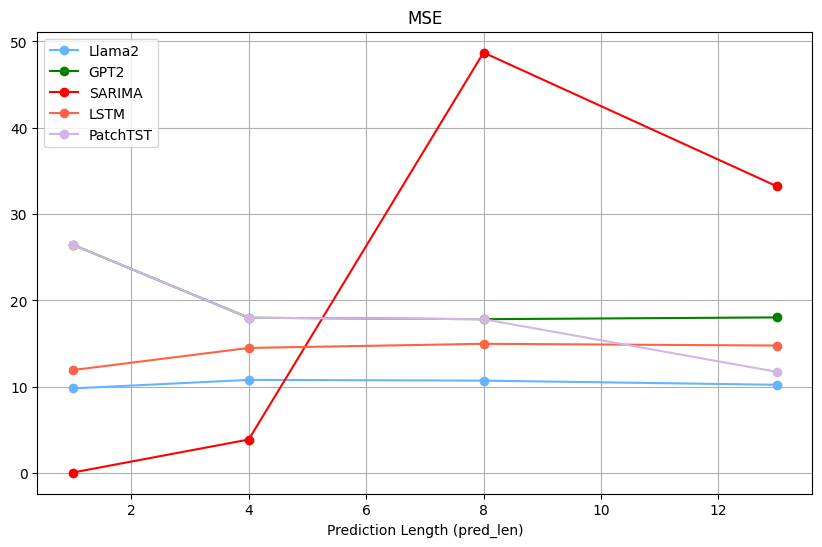

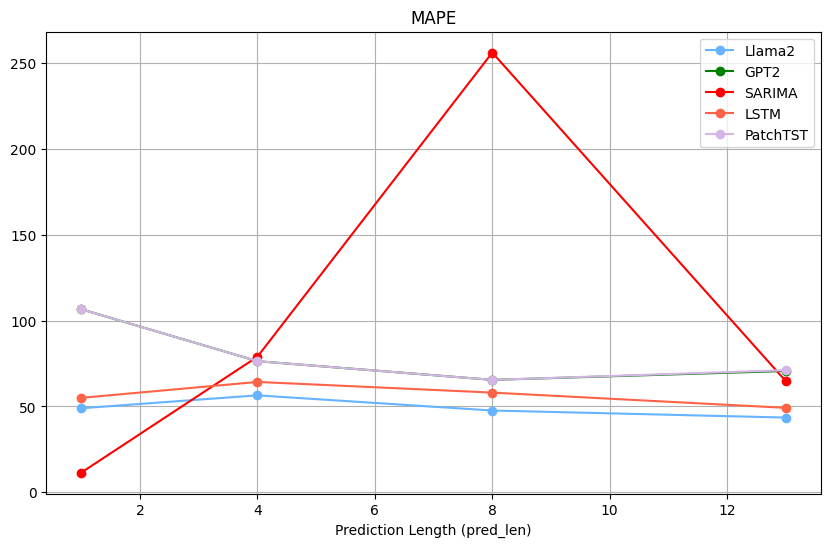

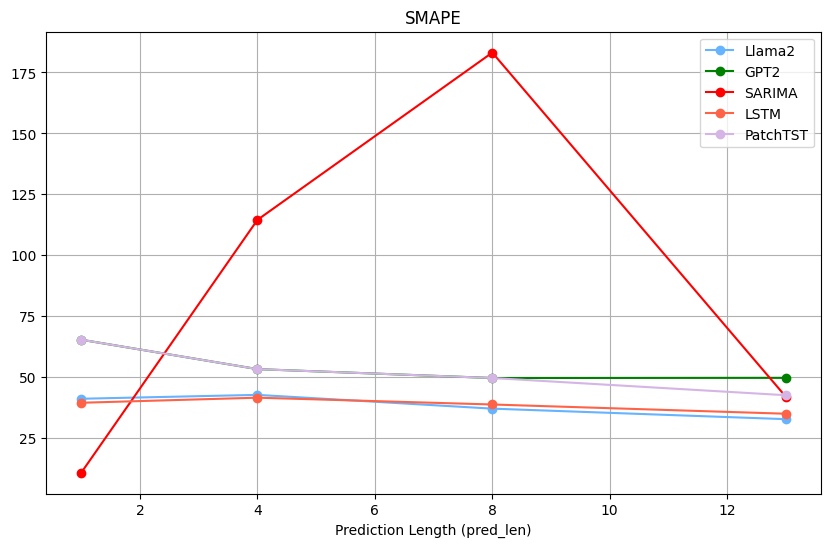

In [9]:
for metric in metrics_visual:
    plt.figure(figsize=(10, 6))

    # 按指定顺序绘制模型
    for model in model_order:
        subset = dt[dt['model'] == model]
        plt.plot(subset['pred_len'], subset[metric], marker='o', label=model, color=model_colors.get(model, 'gray'))
    
    plt.title(f'{metric}')
    plt.xlabel('Prediction Length')
    # plt.ylabel(metric)
    plt.legend()  # 图例会按照绘制顺序显示
    plt.grid(True)
    plt.show()


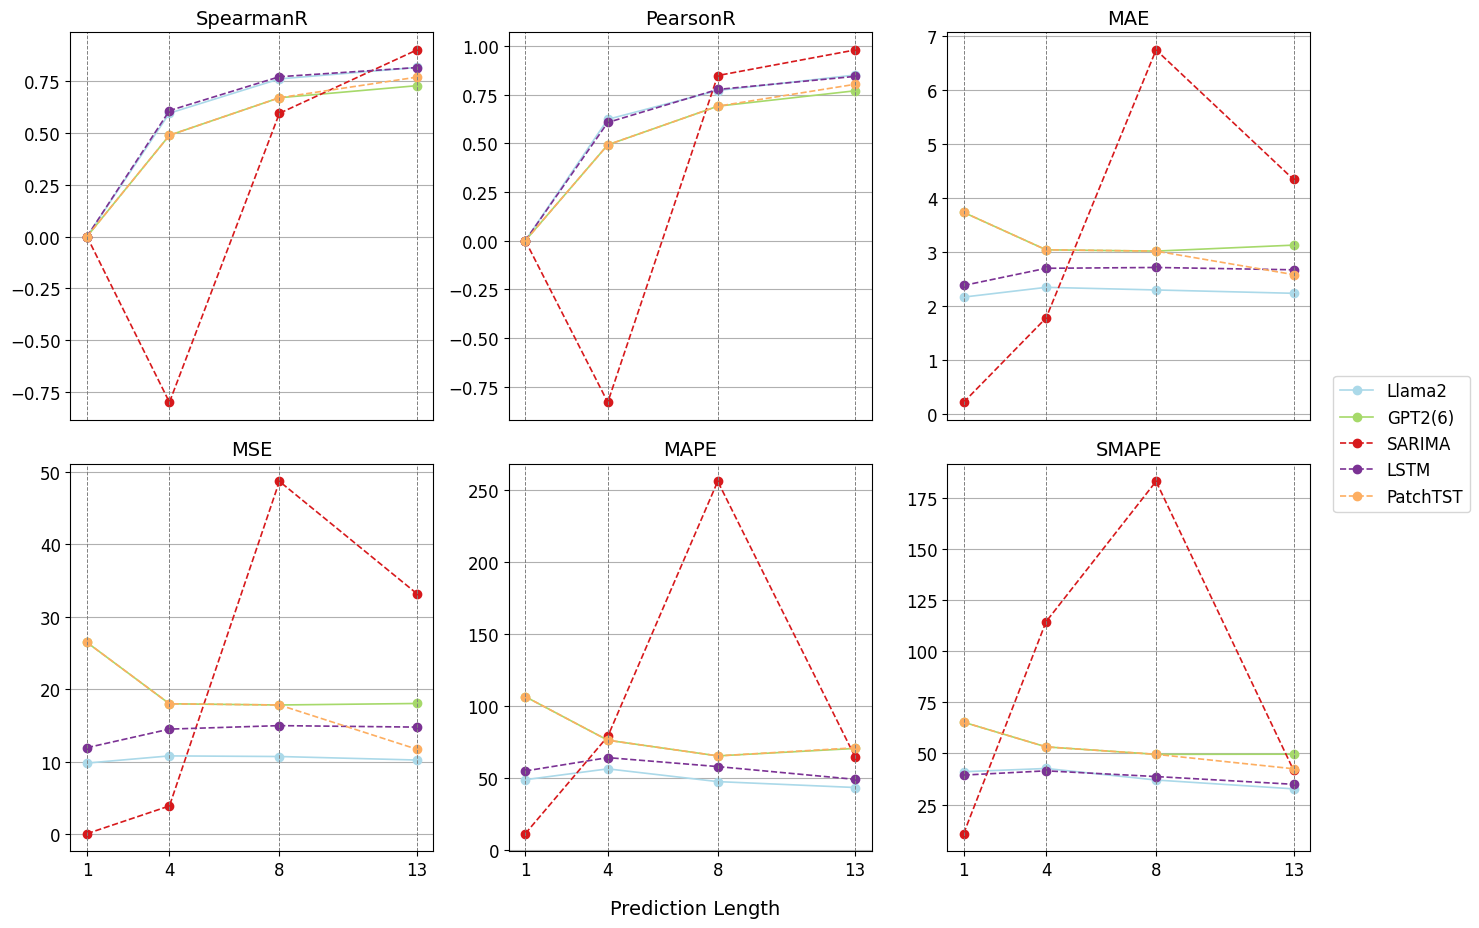

In [5]:
## 正常legend
fig, axes = plt.subplots(2, 3, figsize=(14, 10))
# fig.suptitle('Model Comparison Across Different Metrics', fontsize=18)

# 预测长度的取值范围
pred_lens = dt['pred_len'].unique()

metrics_axes = zip(metrics_visual, axes.flat)

# 在每个子图上绘制
for i, (metric, ax) in enumerate(metrics_axes):
    for model in model_order:
        subset = dt[dt['model'] == model]
        if model == 'Llama2' or model == 'GPT2(6)':
            ax.plot(subset['pred_len'], subset[metric], marker='o', label=model, color=model_colors.get(model, 'gray'), linewidth=1.2)
        else:
            ax.plot(subset['pred_len'], subset[metric], marker='o', linestyle='--', label=model, color=model_colors.get(model, 'gray'), linewidth=1.2)

    # 添加垂直线，只在 pred_len 有值的地方
    for x in pred_lens:
        ax.axvline(x=x, color='grey', linestyle='--', linewidth=0.7)

    ax.set_title(f'{metric}', fontsize=14)
    ax.grid(True, axis='y')
    ax.tick_params(axis='both', labelsize=12)

    ax.set_xticks(pred_lens)
    
    # 移除第一行子图的 x 轴刻度和标签
    if i < 3:
        ax.set_xticks([])

# 添加统一的 x 轴标签
fig.text(0.5, 0.03, 'Prediction Length', ha='center', fontsize=14)

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.95, 0.5), fontsize=12)


# 调整子图布局以适应A4纸张
plt.tight_layout(rect=[0, 0.05, 0.95, 0.95])
plt.savefig(f"/data_disk/lichx/NeurIPS2023-One-Fits-All/Long-term_Forecasting/Output/12_6_png/comparison_of_different_pred_len_with_legend.pdf", format="pdf", bbox_inches='tight')
plt.show()


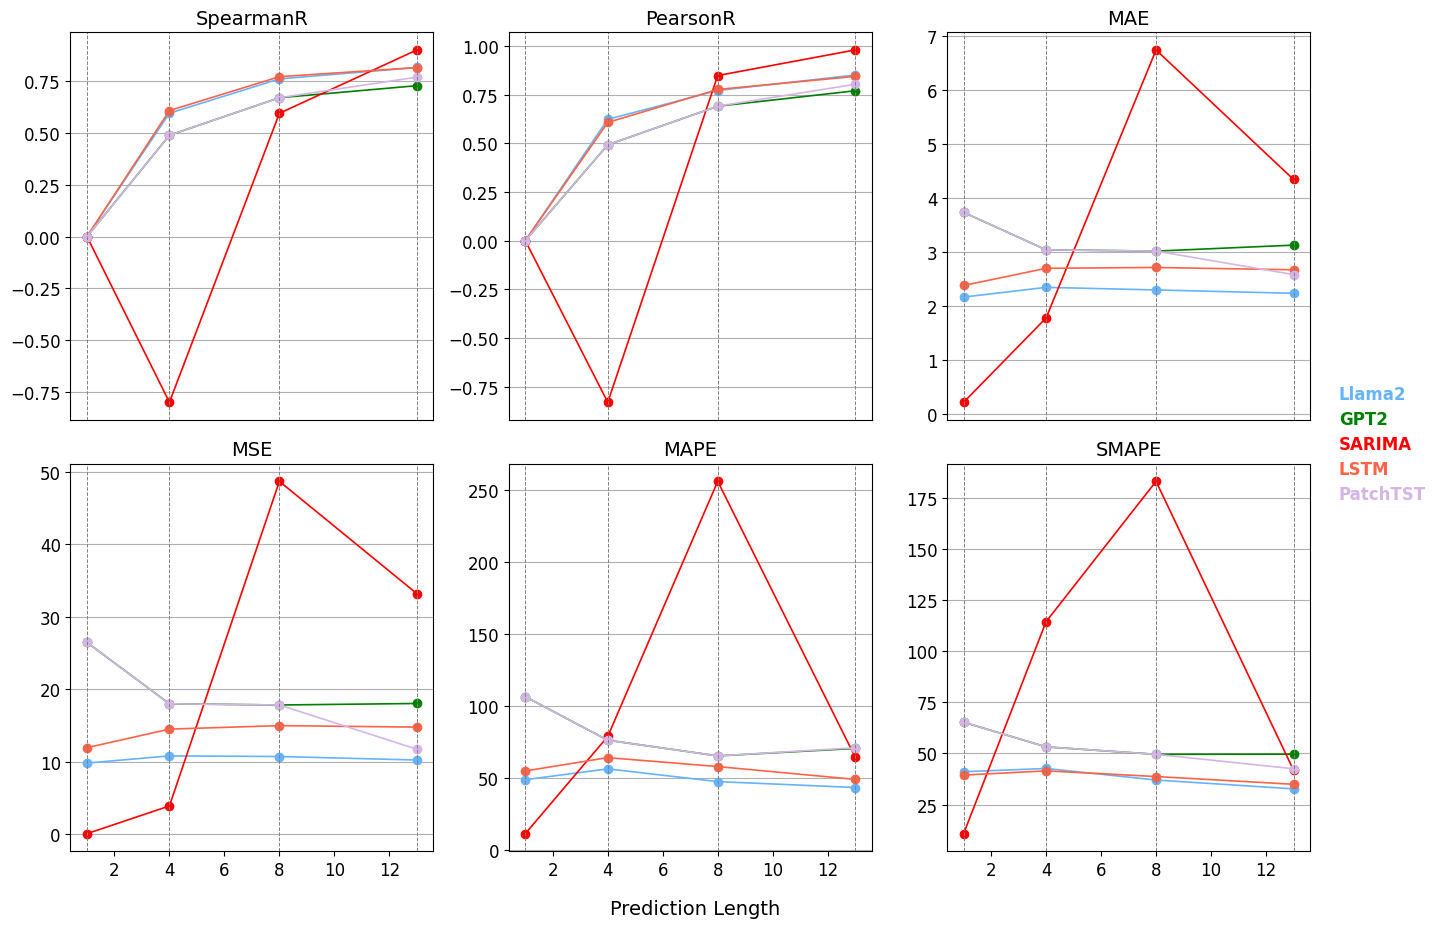

In [32]:
# 设置2x3子图布局，调整尺寸适合A4，修改字体大小
fig, axes = plt.subplots(2, 3, figsize=(14, 10))
# fig.suptitle('Model Comparison Across Different Metrics', fontsize=18)

# 预测长度的取值范围
pred_lens = dt['pred_len'].unique()

metrics_axes = zip(metrics_visual, axes.flat)

# 在每个子图上绘制
for i, (metric, ax) in enumerate(metrics_axes):
    for model in model_order:
        subset = dt[dt['model'] == model]
        ax.plot(subset['pred_len'], subset[metric], marker='o', label=model, color=model_colors.get(model, 'gray'), linewidth=1.2)

    # 添加垂直线，只在 pred_len 有值的地方
    for x in pred_lens:
        ax.axvline(x=x, color='grey', linestyle='--', linewidth=0.7)

    ax.set_title(f'{metric}', fontsize=14)
    ax.grid(True, axis='y')
    ax.tick_params(axis='both', labelsize=12)

    ax.set_xticks(pred_lens)
    
    # 移除第一行子图的 x 轴刻度和标签
    if i < 3:
        ax.set_xticks([])

# 添加统一的 x 轴标签
fig.text(0.5, 0.03, 'Prediction Length', ha='center', fontsize=14)

for i, model in enumerate(model_order):
    plt.figtext(0.96, 0.55 - i * 0.025, model, fontsize=12, fontweight='bold', color=model_colors[model], ha='left', va='center')

# 调整子图布局以适应A4纸张
plt.tight_layout(rect=[0, 0.05, 0.95, 0.95])
plt.savefig(f"/data_disk/lichx/NeurIPS2023-One-Fits-All/Long-term_Forecasting/Output/12_6_png/comparison_of_different_pred_len_no_legend.pdf", format="pdf", bbox_inches='tight')
plt.show()


# 12/6

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker


In [14]:
true = pd.read_csv("/data_disk/lichx/CQ_CDC/2010-2023流感数据/positive_rate_pre.csv", index_col="date")
metrics = pd.read_excel("/data_disk/lichx/NeurIPS2023-One-Fits-All/Long-term_Forecasting/Output/metrics_last_13_week.xlsx", sheet_name=0)
pred = pd.read_excel("/data_disk/lichx/NeurIPS2023-One-Fits-All/Long-term_Forecasting/Output/metrics_last_13_week.xlsx", sheet_name=1, header=0)


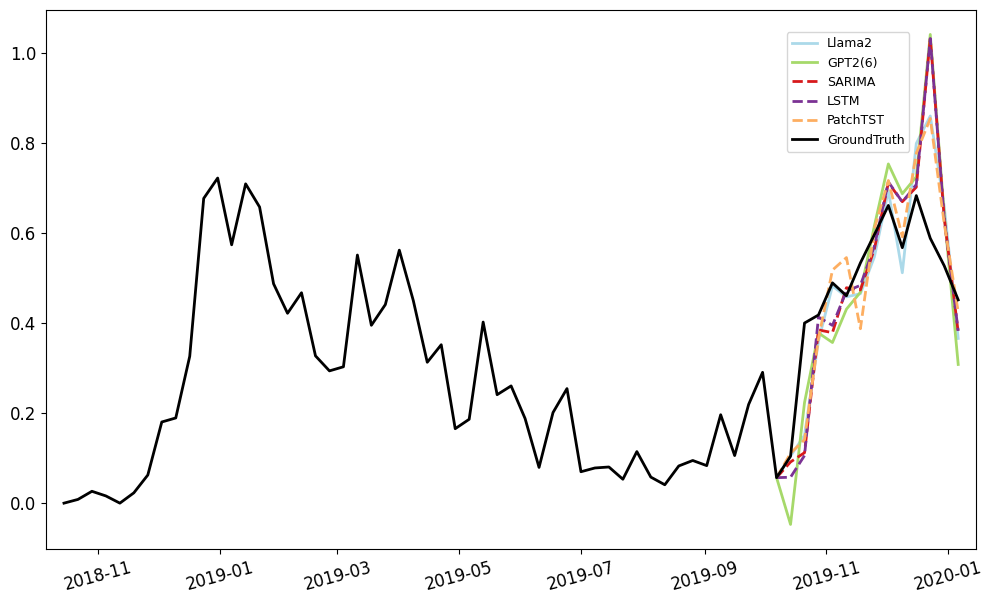

In [17]:
date = pd.to_datetime(true.index[-65:])

GT = true.iloc[-65:].values.reshape(-1)
Llama2 = np.concatenate((GT[-14:-13], pred.iloc[:, 0].values))
GPT2 = np.concatenate((GT[-14:-13], pred.iloc[:, 1].values))
SARIMA = np.concatenate((GT[-14:-13], pred.iloc[:, 2].values))
LSTM = np.concatenate((GT[-14:-13], pred.iloc[:, 3].values))
PatchTST = np.concatenate((GT[-14:-13], pred.iloc[:, 4].values))

plt.figure(figsize=(12, 7))  # 设置画布大小为A4尺寸

# 使用不同的颜色指定每条线
plt.plot(date.values[-14:], Llama2, label=pred.columns[0], color='#abd9e9', linewidth=2, alpha=1)
plt.plot(date.values[-14:], GPT2, label=pred.columns[1]+'(6)', color='#a6d96a', linewidth=2, alpha=1)
plt.plot(date.values[-14:], SARIMA, label=pred.columns[2], color='#d7191c', linestyle='--', linewidth=2, alpha=1)
plt.plot(date.values[-14:], LSTM, label=pred.columns[3], color='#7b3294', linestyle='--', linewidth=2, alpha=1)
plt.plot(date.values[-14:], PatchTST, label=pred.columns[4], color='#fdae61', linestyle='--', linewidth=2, alpha=1)

# 绘制真实值
plt.plot(date.values, GT, label="GroundTruth", color='black', linewidth=2, alpha=1)
left_margin = 0.02  # 左侧留白百分比
right_margin = 0.02  # 右侧留白百分比
x_min = date.values[0] - (date.values[-1] - date.values[0]) * left_margin
x_max = date.values[-1] + (date.values[-1] - date.values[0]) * right_margin
plt.xlim(x_min, x_max)

plt.xticks(fontsize=12, rotation=15)
plt.yticks(fontsize=12)
# 显示图例
# plt.legend(fontsize=12)
plt.legend(loc='upper right', bbox_to_anchor=(0.935, 0.97), fontsize=9)

# 显示图形
plt.savefig("/data_disk/lichx/NeurIPS2023-One-Fits-All/Long-term_Forecasting/Output/12_6_png/pred.pdf", format="pdf", bbox_inches='tight')
plt.show()
plt.close()

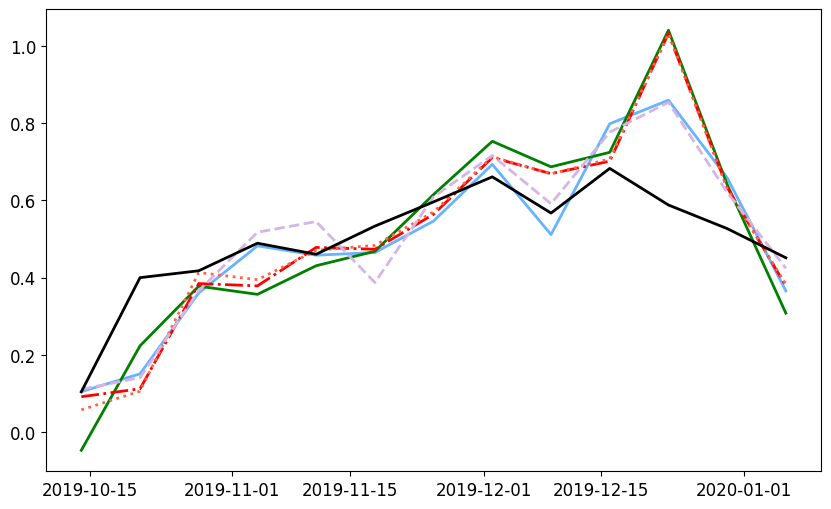

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# 假设 true, pred 和 date 已经正确加载

GT = true.iloc[-13:].values.reshape(-1)
# 预测值
Llama2 = pred.iloc[:, 0].values
GPT2 = pred.iloc[:, 1].values
SARIMA = pred.iloc[:, 2].values
LSTM = pred.iloc[:, 3].values
PatchTST = pred.iloc[:, 4].values

plt.figure(figsize=(10, 6))  # 设置画布大小为A4尺寸

# 使用不同的颜色指定每条线
plt.plot(date.values[-13:], Llama2, label=pred.columns[0], color='#66b3ff', linewidth=2, alpha=1)
plt.plot(date.values[-13:], GPT2, label=pred.columns[1], color='green', linewidth=2, alpha=1)
plt.plot(date.values[-13:], SARIMA, label=pred.columns[2], color='red', linestyle='-.', linewidth=2, alpha=1)
plt.plot(date.values[-13:], LSTM, label=pred.columns[3], color='#ff6347', linestyle=':', linewidth=2, alpha=1)
plt.plot(date.values[-13:], PatchTST, label=pred.columns[4], color='#d5b5e5', linestyle='--', linewidth=2, alpha=1)

# 绘制真实值
plt.plot(date.values[-13:], GT, label="GroundTruth", color='black', linewidth=2, alpha=1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# 显示图例
# plt.legend(fontsize=12)

# 显示图形
plt.savefig("/data_disk/lichx/NeurIPS2023-One-Fits-All/Long-term_Forecasting/Output/12_6_png/pred_2.pdf", format="pdf", bbox_inches='tight')
plt.show()
plt.close()

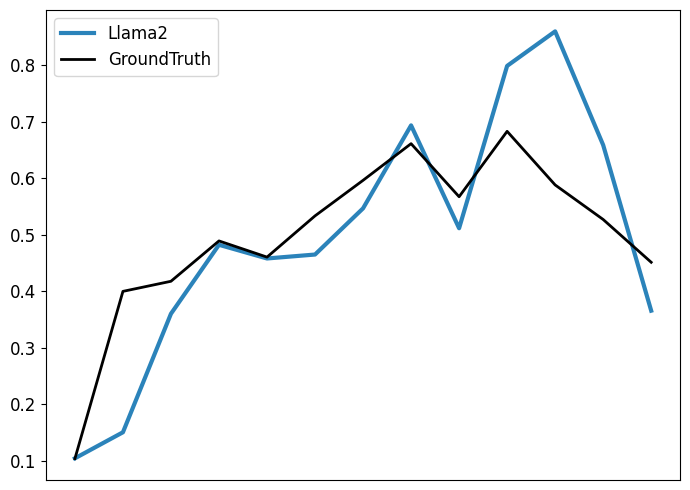

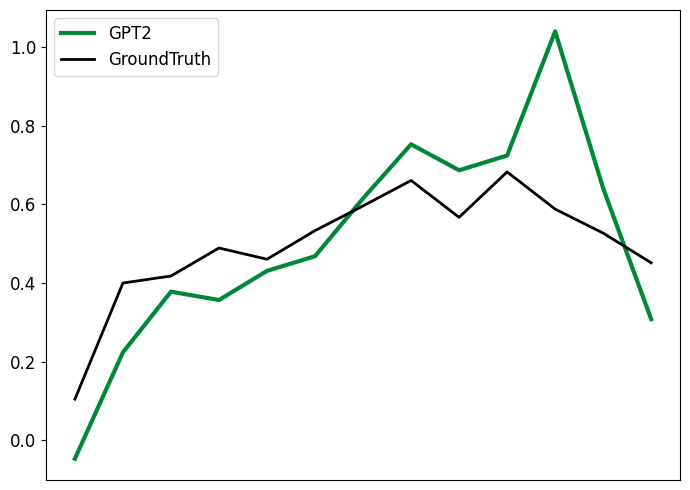

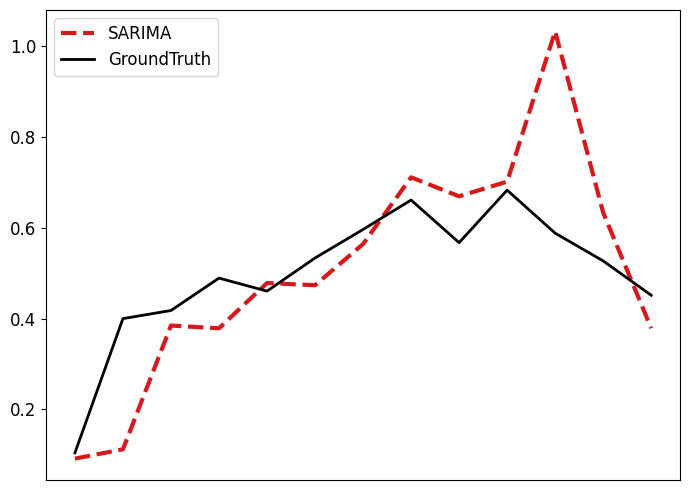

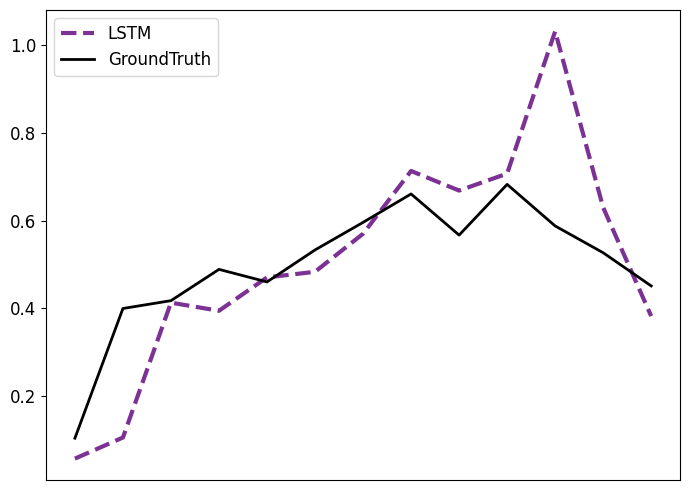

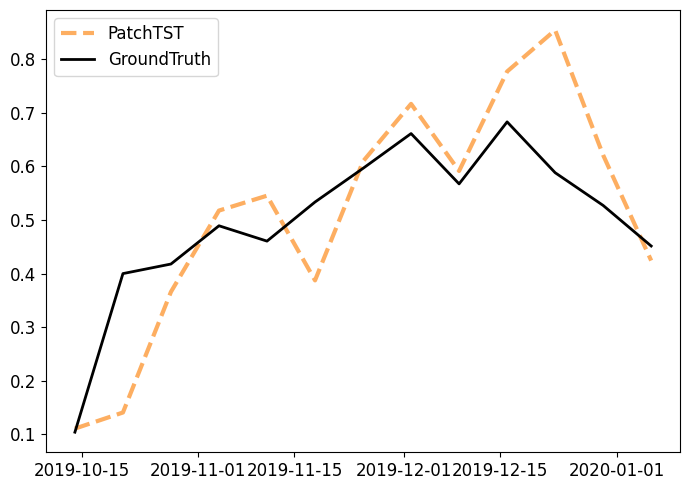

In [12]:
GT = true.iloc[-13:].values.reshape(-1)
# 预测值
Llama2 = pred.iloc[:, 0].values
GPT2 = pred.iloc[:, 1].values
SARIMA = pred.iloc[:, 2].values
LSTM = pred.iloc[:, 3].values
PatchTST = pred.iloc[:, 4].values
# Llama2 Prediction
plt.figure(figsize=(7, 5))
plt.plot(date.values[-13:], Llama2, label=pred.columns[0], color='#2b83ba', linewidth=3, alpha=1)
plt.plot(date.values[-13:], GT, label="GroundTruth", color='black', linewidth=2, alpha=1)
# plt.title('Llama2 Prediction')
# plt.xlabel("Date")
# plt.ylabel("Positive Rate")
plt.legend(fontsize=12)
plt.xticks([], fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("/data_disk/lichx/NeurIPS2023-One-Fits-All/Long-term_Forecasting/Output/12_6_png/Llama2.pdf", bbox_inches='tight')
plt.show()
plt.close()

# GPT2 Prediction
plt.figure(figsize=(7, 5))
plt.plot(date.values[-13:], GPT2, label=pred.columns[1], color='#008837', linewidth=3, alpha=1)
plt.plot(date.values[-13:], GT, label="GroundTruth", color='black', linewidth=2, alpha=1)
# plt.title('GPT2 Prediction')
# plt.xlabel("Date")
# plt.ylabel("Positive Rate")
plt.legend(fontsize=12)
plt.xticks([], fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("/data_disk/lichx/NeurIPS2023-One-Fits-All/Long-term_Forecasting/Output/12_6_png/GPT2.pdf", bbox_inches='tight')
plt.show()
plt.close()

# SARIMA Prediction
plt.figure(figsize=(7, 5))
plt.plot(date.values[-13:], SARIMA, label=pred.columns[2], color='#d7191c', linestyle='--',  linewidth=3, alpha=1)
plt.plot(date.values[-13:], GT, label="GroundTruth", color='black', linewidth=2, alpha=1)
# plt.title('SARIMA Prediction')
# plt.xlabel("Date")
# plt.ylabel("Positive Rate")
plt.legend(fontsize=12)
plt.xticks([], fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("/data_disk/lichx/NeurIPS2023-One-Fits-All/Long-term_Forecasting/Output/12_6_png/SARIMA.pdf", bbox_inches='tight')
plt.show()
plt.close()

# LSTM Prediction
plt.figure(figsize=(7, 5))
plt.plot(date.values[-13:], LSTM, label=pred.columns[3], color='#7b3294', linestyle='--', linewidth=3, alpha=1)
plt.plot(date.values[-13:], GT, label="GroundTruth", color='black', linewidth=2, alpha=1)
# plt.title('LSTM Prediction')
# plt.xlabel("Date")
# plt.ylabel("Positive Rate")
plt.legend(fontsize=12)
plt.xticks([], fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("/data_disk/lichx/NeurIPS2023-One-Fits-All/Long-term_Forecasting/Output/12_6_png/LSTM.pdf", bbox_inches='tight')
plt.show()
plt.close()

# PatchTST Prediction
plt.figure(figsize=(7, 5))
plt.plot(date.values[-13:], PatchTST, label=pred.columns[4], color='#fdae61', linestyle='--', linewidth=3, alpha=1)
plt.plot(date.values[-13:], GT, label="GroundTruth", color='black', linewidth=2, alpha=1)
# plt.title('PatchTST Prediction')
# plt.xlabel("Date")
# plt.ylabel("Positive Rate")
plt.legend(fontsize=12)
plt.grid(False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.xticks(ha="right")
plt.tight_layout()
plt.savefig("/data_disk/lichx/NeurIPS2023-One-Fits-All/Long-term_Forecasting/Output/12_6_png/PatchTST.pdf", bbox_inches='tight')
plt.show()
plt.close()


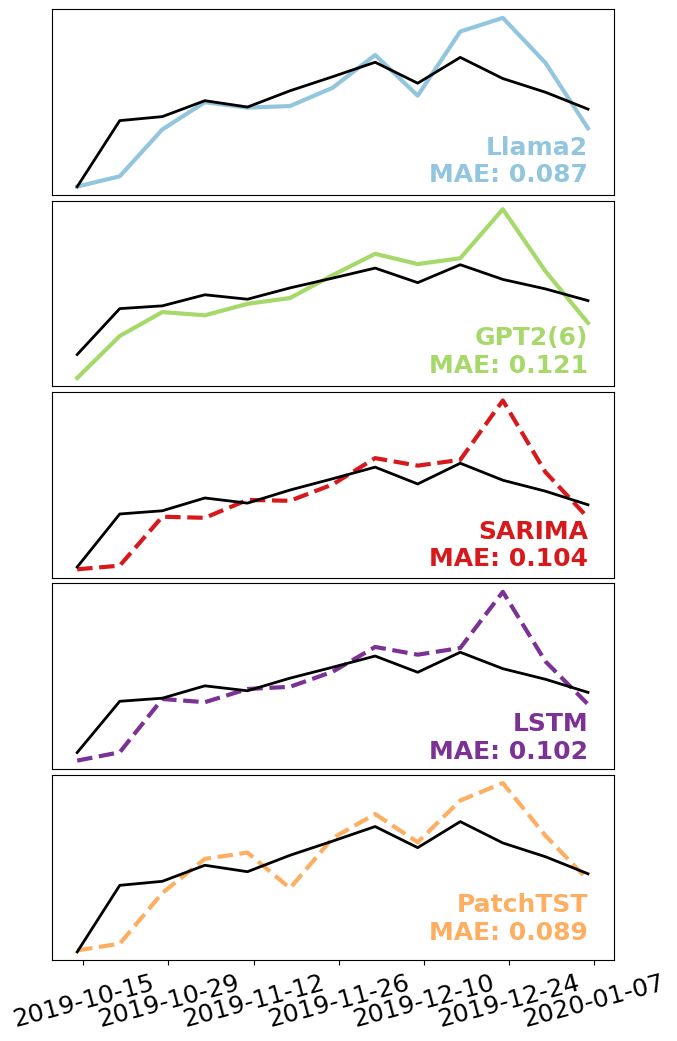

In [19]:
GT = true.iloc[-13:].values.reshape(-1)

# 预测值
Llama2 = pred.iloc[:, 0].values
GPT2 = pred.iloc[:, 1].values
SARIMA = pred.iloc[:, 2].values
LSTM = pred.iloc[:, 3].values
PatchTST = pred.iloc[:, 4].values
metric = 'MAE'
ratio = 0.6
# 创建5个子图
fig, axes = plt.subplots(5, 1, figsize=(7.25, 12.35), sharex=True)
fontsize = 18
# Llama2 Prediction
axes[0].plot(date.values[-13:], Llama2, label=pred.columns[0], color='#92c5de', linewidth=3, alpha=1)
axes[0].plot(date.values[-13:], GT, label="GroundTruth", color='black', linewidth=2, alpha=1)
axes[0].text(date.values[-1], Llama2[-1]*ratio, f"Llama2\nMAE: {metrics[f'{metric}'][0]:.3f}", color='#92c5de', fontsize=fontsize, ha='right', va='center', fontweight='bold')
# axes[0].legend(fontsize=fontsize)
axes[0].set_xticklabels([])  # 去掉x轴刻度标签
axes[0].tick_params(axis='x', which='both', bottom=False, top=False)  # 去掉x轴刻度
axes[0].set_yticks([])  # 去掉y轴刻度
axes[0].set_yticklabels([])  # 去掉y轴标签

# GPT2 Prediction
axes[1].plot(date.values[-13:], GPT2, label=pred.columns[1]+'(6)', color='#a6d96a', linewidth=3, alpha=1)
axes[1].plot(date.values[-13:], GT, label="GroundTruth", color='black', linewidth=2, alpha=1)
axes[1].text(date.values[-1], GPT2[-1]*0.4, f"GPT2(6)\nMAE: {metrics[f'{metric}'][1]:.3f}", color='#a6d96a', fontsize=fontsize, ha='right', va='center', fontweight='bold')
# axes[1].legend(fontsize=fontsize)
axes[1].set_xticklabels([])  # 去掉x轴刻度标签
axes[1].tick_params(axis='x', which='both', bottom=False, top=False)  # 去掉x轴刻度
axes[1].set_yticks([])  # 去掉y轴刻度
axes[1].set_yticklabels([])  # 去掉y轴标签

# SARIMA Prediction
axes[2].plot(date.values[-13:], SARIMA, label=pred.columns[2], color='#d7191c', linestyle='--', linewidth=3, alpha=1)
axes[2].plot(date.values[-13:], GT, label="GroundTruth", color='black', linewidth=2, alpha=1)
axes[2].text(date.values[-1], SARIMA[-1]*ratio, f"SARIMA\nMAE: {metrics[f'{metric}'][2]:.3f}", color='#d7191c', fontsize=fontsize, ha='right', va='center', fontweight='bold')
# axes[2].legend(fontsize=fontsize)
axes[2].set_xticklabels([]) 
axes[2].tick_params(axis='x', which='both', bottom=False, top=False)  # 去掉x轴刻度
axes[2].set_yticks([])  # 去掉y轴刻度
axes[2].set_yticklabels([])  # 去掉y轴标签

# LSTM Prediction
axes[3].plot(date.values[-13:], LSTM, label=pred.columns[3], color='#7b3294', linestyle='--', linewidth=3, alpha=1)
axes[3].plot(date.values[-13:], GT, label="GroundTruth", color='black', linewidth=2, alpha=1)
axes[3].text(date.values[-1], LSTM[-1]*0.5, f"LSTM\nMAE: {metrics[f'{metric}'][3]:.3f}", color='#7b3294', fontsize=fontsize, ha='right', va='center', fontweight='bold')
# axes[3].legend(fontsize=fontsize)
axes[3].set_xticklabels([]) 
axes[3].tick_params(axis='x', which='both', bottom=False, top=False)  # 去掉x轴刻度
axes[3].set_yticks([])  # 去掉y轴刻度
axes[3].set_yticklabels([])  # 去掉y轴标签

# PatchTST Prediction
axes[4].plot(date.values[-13:], PatchTST, label=pred.columns[4], color='#fdae61', linestyle='--', linewidth=3, alpha=1)
axes[4].plot(date.values[-13:], GT, label="GroundTruth", color='black', linewidth=2, alpha=1)
axes[4].text(date.values[-1], PatchTST[-1]*ratio, f"PatchTST\nMAE: {metrics[f'{metric}'][4]:.3f}", color='#fdae61', fontsize=fontsize, ha='right', va='center', fontweight='bold')
# axes[4].legend(fontsize=fontsize)
# axes[4].tick_params(axis='x', which='both', bottom=False, top=False)  # 去掉x轴刻度
axes[4].tick_params(axis='x', labelsize=fontsize)
# axes[4].xaxis.set_major_locator(ticker.MaxNLocator(nbins=4))
axes[4].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axes[4].xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
axes[4].set_yticks([])  # 去掉y轴刻度
axes[4].set_yticklabels([])  # 去掉y轴标签
for tick in axes[4].get_xticklabels():
    tick.set_rotation(15) 

# plt.xlabel("Date", fontsize=14)
plt.subplots_adjust(hspace=0.03)
# plt.tight_layout()

plt.savefig("/data_disk/lichx/NeurIPS2023-One-Fits-All/Long-term_Forecasting/Output/12_6_png/All_Model_Predictions_with_legend.pdf", bbox_inches='tight')
plt.show()
